# EDA - Análise de Hipóteses sobre Gastos dos Deputados

Este notebook analisa 5 hipóteses específicas sobre os gastos dos deputados federais usando os dados do Snowflake através dos modelos dbt.

## Configuração Inicial

In [2]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import snowflake.connector
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

d:\projetos\pipeline-deputados\.venv\Lib\site-packages\snowflake\connector\options.py:104: UserWarning: You have an incompatible version of 'pyarrow' installed (21.0.0), please install a version that adheres to: 'pyarrow<19.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [3]:
# Carregar variáveis de ambiente
load_dotenv('dashboard/.env')

# Configuração da conexão com Snowflake
def create_snowflake_connection():
    """Cria conexão com Snowflake usando variáveis de ambiente"""
    try:
        conn = snowflake.connector.connect(
            user=os.getenv('SNOWFLAKE_USER'),
            password=os.getenv('SNOWFLAKE_PASSWORD'),
            account=os.getenv('SNOWFLAKE_ACCOUNT'),
            warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
            database=os.getenv('SNOWFLAKE_DATABASE'),
            schema=os.getenv('SNOWFLAKE_SCHEMA'),
            role=os.getenv('SNOWFLAKE_ROLE')
        )
        print("✅ Conexão com Snowflake estabelecida com sucesso!")
        return conn
    except Exception as e:
        print(f"❌ Erro ao conectar com Snowflake: {e}")
        return None

conn = create_snowflake_connection()

✅ Conexão com Snowflake estabelecida com sucesso!


In [4]:
# Função auxiliar para executar queries
def execute_query(query, conn):
    """Executa query e retorna DataFrame"""
    try:
        cursor = conn.cursor()
        cursor.execute(query)
        df = cursor.fetch_pandas_all()
        cursor.close()
        return df
    except Exception as e:
        print(f"Erro ao executar query: {e}")
        return None

# Função para formatar valores monetários
def format_currency(value):
    """Formata valores em formato monetário brasileiro"""
    return f"R$ {value:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')

## Visão Geral dos Dados

Primeiro, vamos entender a estrutura e volume dos dados disponíveis nos modelos dbt.

In [5]:
# Visão geral dos dados
overview_query = """
SELECT 
    COUNT(DISTINCT dd.nk_deputado) as total_deputados,
    COUNT(DISTINCT dd.sigla_uf) as total_ufs,
    COUNT(DISTINCT dd.sigla_partido) as total_partidos,
    COUNT(f.cod_documento) as total_despesas,
    SUM(f.valor_liquido) as valor_total,
    MIN(dt.ano) as ano_inicio,
    MAX(dt.ano) as ano_fim
FROM fct_despesas f
INNER JOIN dim_deputados dd ON f.sk_deputado = dd.sk_deputado
INNER JOIN dim_tempo dt ON f.sk_tempo = dt.sk_tempo
"""

overview_df = execute_query(overview_query, conn)

if overview_df is not None and len(overview_df) > 0:
    print("📊 Visão Geral dos Dados:")
    print(f"Total de Deputados: {overview_df['TOTAL_DEPUTADOS'].iloc[0]:,}")
    print(f"Total de UFs: {overview_df['TOTAL_UFS'].iloc[0]}")
    print(f"Total de Partidos: {overview_df['TOTAL_PARTIDOS'].iloc[0]}")
    print(f"Total de Despesas: {overview_df['TOTAL_DESPESAS'].iloc[0]:,}")
    print(f"Valor Total: {format_currency(overview_df['VALOR_TOTAL'].iloc[0])}")
    print(f"Período: {overview_df['ANO_INICIO'].iloc[0]} - {overview_df['ANO_FIM'].iloc[0]}")
else:
    print("❌ Não foi possível carregar dados de overview.")

📊 Visão Geral dos Dados:
Total de Deputados: 529
Total de UFs: 27
Total de Partidos: 35
Total de Despesas: 4,577,842
Valor Total: R$ 4.232.957.569,00
Período: 2022 - 2025


# Hipótese 1: Diferença Regional no Gasto Médio

**Hipótese:** Deputados do Nordeste apresentam gasto médio anual 20% superior ao gasto médio dos deputados do Sul.

Vamos classificar as UFs por região e comparar os gastos médios.

In [6]:
# Classificação das regiões brasileiras
regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

# Query para gasto médio por deputado por UF e ano
gasto_regional_query = """
SELECT 
    dd.sigla_uf,
    dt.ano,
    dd.nk_deputado,
    SUM(f.valor_liquido) as gasto_total_deputado
FROM fct_despesas f
INNER JOIN dim_deputados dd ON f.sk_deputado = dd.sk_deputado
INNER JOIN dim_tempo dt ON f.sk_tempo = dt.sk_tempo
GROUP BY dd.sigla_uf, dt.ano, dd.nk_deputado
"""

gasto_deputado_df = execute_query(gasto_regional_query, conn)

if gasto_deputado_df is not None and len(gasto_deputado_df) > 0:
    # Adicionar região
    def get_regiao(uf):
        for regiao, ufs in regioes.items():
            if uf in ufs:
                return regiao
        return 'Não identificado'

    gasto_deputado_df['REGIAO'] = gasto_deputado_df['SIGLA_UF'].apply(get_regiao)

    # Calcular gasto médio por região e ano
    gasto_regional = gasto_deputado_df.groupby(['REGIAO', 'ANO']).agg({
        'GASTO_TOTAL_DEPUTADO': 'mean'
    }).reset_index()

    print("💰 Gasto Médio Anual por Deputado por Região:")
    gasto_por_regiao = gasto_regional.groupby('REGIAO')['GASTO_TOTAL_DEPUTADO'].mean().sort_values(ascending=False)
    
    for regiao, valor in gasto_por_regiao.items():
        print(f"{regiao}: {format_currency(valor)}")

    # Testar hipótese específica: Nordeste vs Sul
    if 'Nordeste' in gasto_por_regiao.index and 'Sul' in gasto_por_regiao.index:
        nordeste_media = gasto_por_regiao['Nordeste']
        sul_media = gasto_por_regiao['Sul']
        diferenca_percentual = ((nordeste_media - sul_media) / sul_media) * 100

        print(f"\n🔍 Teste da Hipótese 1:")
        print(f"Gasto médio Nordeste: {format_currency(nordeste_media)}")
        print(f"Gasto médio Sul: {format_currency(sul_media)}")
        print(f"Diferença percentual: {diferenca_percentual:.1f}%")
        print(f"Hipótese confirmada (≥20%): {'✅ SIM' if diferenca_percentual >= 20 else '❌ NÃO'}")
    else:
        print("❌ Dados insuficientes para comparar Nordeste vs Sul")
else:
    print("❌ Não foi possível carregar dados regionais.")

💰 Gasto Médio Anual por Deputado por Região:
Norte: R$ 2.185.771,93
Sudeste: R$ 2.135.715,88
Nordeste: R$ 2.119.386,78
Sul: R$ 1.996.298,57
Centro-Oeste: R$ 1.750.156,79

🔍 Teste da Hipótese 1:
Gasto médio Nordeste: R$ 2.119.386,78
Gasto médio Sul: R$ 1.996.298,57
Diferença percentual: 6.2%
Hipótese confirmada (≥20%): ❌ NÃO


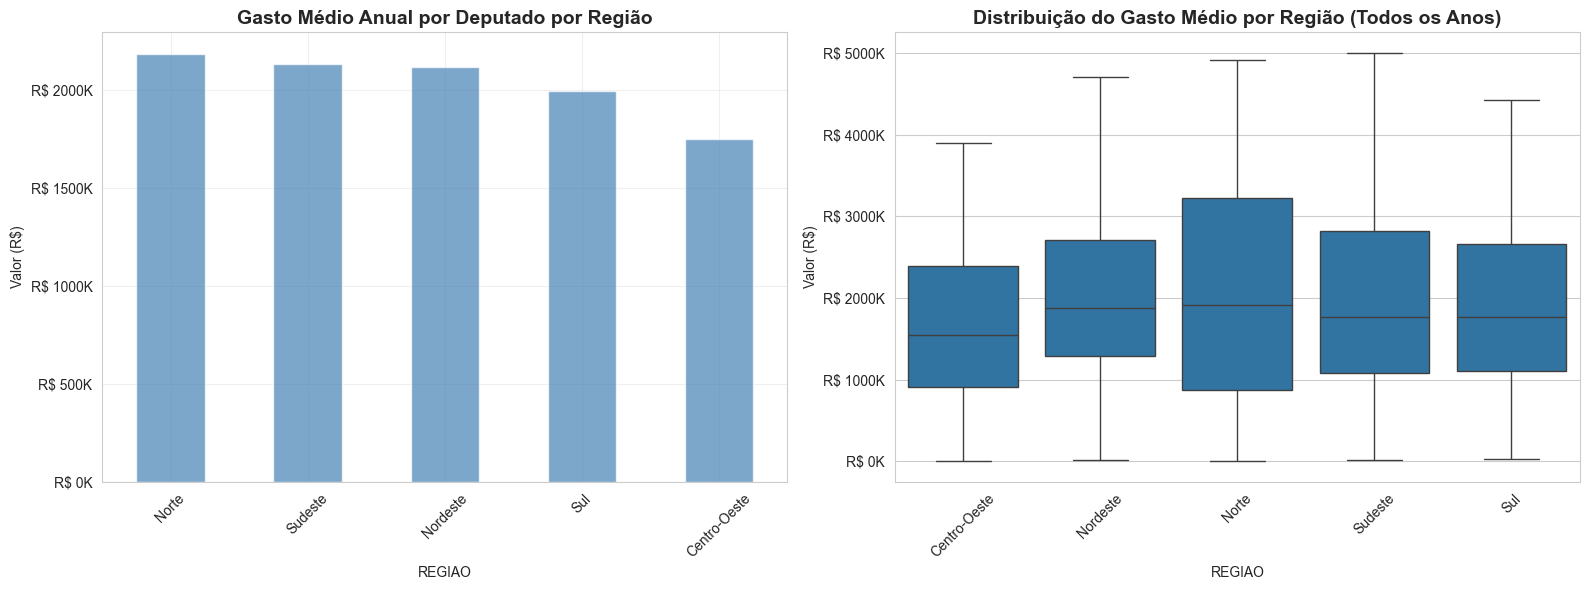


📈 Análise Estatística por Região:
                   mean     median        std
REGIAO                                       
Centro-Oeste 1750156.79 1549163.82 1633533.03
Nordeste     2119386.78 1878268.08 1938230.94
Norte        2185771.93 1911059.77 2117327.30
Sudeste      2135715.88 1762397.73 2096400.59
Sul          1996298.57 1766911.36 1829794.29


In [7]:
# Visualização da Hipótese 1
if gasto_deputado_df is not None and len(gasto_deputado_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfico de barras por região
    gasto_por_regiao.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
    ax1.set_title('Gasto Médio Anual por Deputado por Região', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Valor (R$)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
    ax1.grid(True, alpha=0.3)

    # Box plot por região ao longo dos anos
    sns.boxplot(data=gasto_regional, x='REGIAO', y='GASTO_TOTAL_DEPUTADO', ax=ax2)
    ax2.set_title('Distribuição do Gasto Médio por Região (Todos os Anos)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Valor (R$)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))

    plt.tight_layout()
    plt.show()

    # Análise estatística adicional
    print("\n📈 Análise Estatística por Região:")
    stats_regiao = gasto_regional.groupby('REGIAO')['GASTO_TOTAL_DEPUTADO'].agg(['mean', 'median', 'std']).round(2)
    print(stats_regiao)

# Hipótese 2: Concentração de Gastos em Poucos Deputados

**Hipótese:** Os 10% de deputados mais gastadores são responsáveis por mais de 40% do total das despesas anuais.

Vamos analisar a concentração de gastos usando a análise de Pareto.

In [8]:
# Query para gasto total por deputado por ano
concentracao_query = """
SELECT 
    dd.nk_deputado,
    dd.nome_deputado,
    dd.sigla_uf,
    dt.ano,
    SUM(f.valor_liquido) as gasto_total_deputado
FROM fct_despesas f
INNER JOIN dim_deputados dd ON f.sk_deputado = dd.sk_deputado
INNER JOIN dim_tempo dt ON f.sk_tempo = dt.sk_tempo
GROUP BY dd.nk_deputado, dd.nome_deputado, dd.sigla_uf, dt.ano
ORDER BY dt.ano, gasto_total_deputado DESC
"""

concentracao_df = execute_query(concentracao_query, conn)

if concentracao_df is not None and len(concentracao_df) > 0:
    print("🎯 Análise de Concentração de Gastos:")

    concentracao_resultados = []

    for ano in sorted(concentracao_df['ANO'].unique()):
        ano_df = concentracao_df[concentracao_df['ANO'] == ano].copy()
        
        total_deputados = len(ano_df)
        top_10_percent = max(1, int(total_deputados * 0.1))  # Pelo menos 1 deputado
        
        total_gasto_ano = ano_df['GASTO_TOTAL_DEPUTADO'].sum()
        gasto_top_10_percent = ano_df.head(top_10_percent)['GASTO_TOTAL_DEPUTADO'].sum()
        
        percentual_concentracao = (gasto_top_10_percent / total_gasto_ano) * 100
        
        concentracao_resultados.append({
            'ano': ano,
            'total_deputados': total_deputados,
            'top_10_percent': top_10_percent,
            'concentracao': percentual_concentracao
        })
        
        print(f"\n📅 Ano {ano}:")
        print(f"  Total deputados: {total_deputados}")
        print(f"  Top 10% deputados: {top_10_percent}")
        print(f"  Concentração de gastos: {percentual_concentracao:.1f}%")
        print(f"  Hipótese confirmada (>40%): {'✅ SIM' if percentual_concentracao > 40 else '❌ NÃO'}")

    # Análise geral
    concentracao_geral_df = pd.DataFrame(concentracao_resultados)
    media_concentracao = concentracao_geral_df['concentracao'].mean()
    
    print(f"\n🔍 Concentração média nos anos analisados: {media_concentracao:.1f}%")
    print(f"Hipótese geral confirmada: {'✅ SIM' if media_concentracao > 40 else '❌ NÃO'}")
else:
    print("❌ Não foi possível carregar dados de concentração.")

🎯 Análise de Concentração de Gastos:

📅 Ano 2022:
  Total deputados: 26
  Top 10% deputados: 2
  Concentração de gastos: 43.4%
  Hipótese confirmada (>40%): ✅ SIM

📅 Ano 2023:
  Total deputados: 498
  Top 10% deputados: 49
  Concentração de gastos: 38.9%
  Hipótese confirmada (>40%): ❌ NÃO

📅 Ano 2024:
  Total deputados: 518
  Top 10% deputados: 51
  Concentração de gastos: 43.5%
  Hipótese confirmada (>40%): ✅ SIM

📅 Ano 2025:
  Total deputados: 522
  Top 10% deputados: 52
  Concentração de gastos: 40.3%
  Hipótese confirmada (>40%): ✅ SIM

🔍 Concentração média nos anos analisados: 41.6%
Hipótese geral confirmada: ✅ SIM


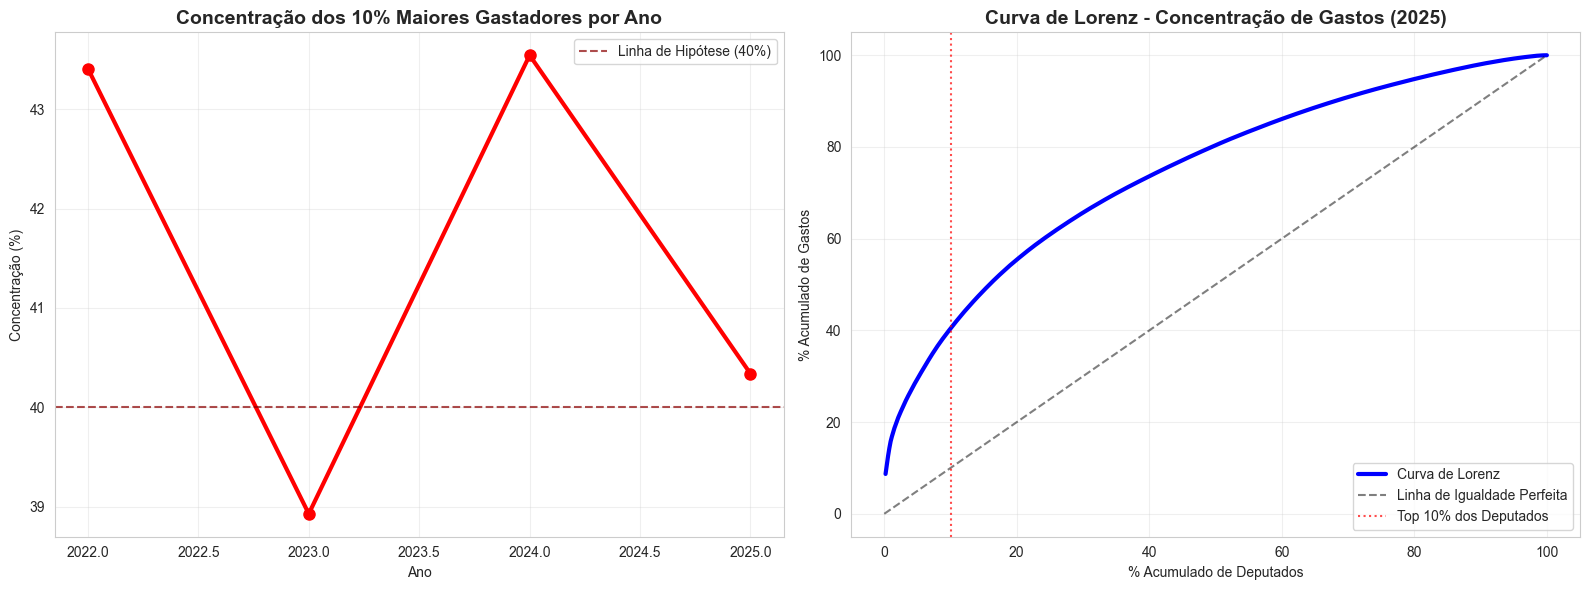


🔝 Top 10 Maiores Gastadores - 2025:
 1. ARTHUR LIRA (AL): R$ 66.001.607,00
 2. CARLA ZAMBELLI (SP): R$ 15.417.616,00
 3. ADRIANA VENTURA (SP): R$ 14.600.934,00
 4. MARCOS SOARES (RJ): R$ 12.851.298,00
 5. FILIPE BARROS (PR): R$ 11.117.055,00
 6. CORONEL MEIRA (PE): R$ 8.083.218,00
 7. RICARDO SALLES (SP): R$ 7.297.586,00
 8. CARLOS VERAS (PE): R$ 6.706.742,00
 9. PASTOR EURICO (PE): R$ 5.940.462,00
10. CELSO RUSSOMANNO (SP): R$ 5.751.154,00


In [9]:
# Visualização da concentração de gastos
if concentracao_df is not None and len(concentracao_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Evolução da concentração por ano
    if len(concentracao_resultados) > 1:
        anos = [r['ano'] for r in concentracao_resultados]
        concentracoes = [r['concentracao'] for r in concentracao_resultados]
        
        ax1.plot(anos, concentracoes, marker='o', linewidth=3, markersize=8, color='red')
        ax1.axhline(y=40, color='darkred', linestyle='--', alpha=0.7, label='Linha de Hipótese (40%)')
        ax1.set_title('Concentração dos 10% Maiores Gastadores por Ano', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Ano')
        ax1.set_ylabel('Concentração (%)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

    # Curva de Lorenz para o ano mais recente
    ano_recente = concentracao_df['ANO'].max()
    dados_lorenz = concentracao_df[concentracao_df['ANO'] == ano_recente].sort_values('GASTO_TOTAL_DEPUTADO', ascending=False).reset_index(drop=True)
    
    dados_lorenz['percentual_deputados'] = (np.arange(1, len(dados_lorenz) + 1) / len(dados_lorenz)) * 100
    dados_lorenz['percentual_gastos_acum'] = (dados_lorenz['GASTO_TOTAL_DEPUTADO'].cumsum() / dados_lorenz['GASTO_TOTAL_DEPUTADO'].sum()) * 100

    ax2.plot(dados_lorenz['percentual_deputados'], dados_lorenz['percentual_gastos_acum'], 
             linewidth=3, color='blue', label='Curva de Lorenz')
    ax2.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Linha de Igualdade Perfeita')
    ax2.axvline(x=10, color='red', linestyle=':', alpha=0.7, label='Top 10% dos Deputados')
    ax2.set_title(f'Curva de Lorenz - Concentração de Gastos ({ano_recente})', fontsize=14, fontweight='bold')
    ax2.set_xlabel('% Acumulado de Deputados')
    ax2.set_ylabel('% Acumulado de Gastos')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Mostrar os maiores gastadores do ano mais recente
    print(f"\n🔝 Top 10 Maiores Gastadores - {ano_recente}:")
    top_gastadores = dados_lorenz.head(10)
    for i, (_, dep) in enumerate(top_gastadores.iterrows(), 1):
        print(f"{i:2d}. {dep['NOME_DEPUTADO']} ({dep['SIGLA_UF']}): {format_currency(dep['GASTO_TOTAL_DEPUTADO'])}")

# Hipótese 3: Sazonalidade nos Gastos

**Hipótese:** O 4º trimestre apresenta aumento médio de 15% nas despesas em relação ao 1º trimestre.

Vamos analisar os padrões sazonais nos gastos dos deputados.

In [10]:
# Query para gastos por trimestre
sazonalidade_query = """
SELECT 
    dt.ano,
    dt.trimestre,
    dt.mes,
    dt.nome_mes,
    COUNT(f.cod_documento) as qtd_despesas,
    SUM(f.valor_liquido) as total_gasto,
    AVG(f.valor_liquido) as media_gasto
FROM fct_despesas f
INNER JOIN dim_tempo dt ON f.sk_tempo = dt.sk_tempo
GROUP BY dt.ano, dt.trimestre, dt.mes, dt.nome_mes
ORDER BY dt.ano, dt.trimestre, dt.mes
"""

sazonalidade_df = execute_query(sazonalidade_query, conn)

if sazonalidade_df is not None and len(sazonalidade_df) > 0:
    print("📈 Análise de Sazonalidade por Trimestre:")

    # Análise por trimestre
    gastos_trimestre = sazonalidade_df.groupby(['ANO', 'TRIMESTRE']).agg({
        'TOTAL_GASTO': 'sum',
        'QTD_DESPESAS': 'sum'
    }).reset_index()

    sazonalidade_resultados = []

    for ano in sorted(gastos_trimestre['ANO'].unique()):
        ano_data = gastos_trimestre[gastos_trimestre['ANO'] == ano]
        
        if len(ano_data) >= 2:  # Precisa ter pelo menos 2 trimestres
            t1_data = ano_data[ano_data['TRIMESTRE'] == 1]
            t4_data = ano_data[ano_data['TRIMESTRE'] == 4]
            
            if len(t1_data) > 0 and len(t4_data) > 0:
                t1_gasto = t1_data['TOTAL_GASTO'].iloc[0]
                t4_gasto = t4_data['TOTAL_GASTO'].iloc[0]
                
                variacao = ((t4_gasto - t1_gasto) / t1_gasto) * 100
                
                sazonalidade_resultados.append({
                    'ano': ano,
                    't1_gasto': t1_gasto,
                    't4_gasto': t4_gasto,
                    'variacao': variacao
                })
                
                print(f"\n📅 Ano {ano}:")
                print(f"  1º Trimestre: {format_currency(t1_gasto)}")
                print(f"  4º Trimestre: {format_currency(t4_gasto)}")
                print(f"  Variação T4 vs T1: {variacao:+.1f}%")
                print(f"  Hipótese confirmada (≥+15%): {'✅ SIM' if variacao >= 15 else '❌ NÃO'}")

    # Análise média geral
    if sazonalidade_resultados:
        sazonalidade_resultados_df = pd.DataFrame(sazonalidade_resultados)
        variacao_media = sazonalidade_resultados_df['variacao'].mean()
        
        print(f"\n🔍 Variação média T4 vs T1 (todos os anos): {variacao_media:+.1f}%")
        print(f"Hipótese geral confirmada: {'✅ SIM' if variacao_media >= 15 else '❌ NÃO'}")

    # Análise mensal detalhada
    print(f"\n📊 Gastos Médios por Trimestre (todos os anos):")
    media_trimestre = gastos_trimestre.groupby('TRIMESTRE')['TOTAL_GASTO'].mean()
    for trim, valor in media_trimestre.items():
        print(f"  {trim}º Trimestre: {format_currency(valor)}")
else:
    print("❌ Não foi possível carregar dados de sazonalidade.")

📈 Análise de Sazonalidade por Trimestre:

📅 Ano 2023:
  1º Trimestre: R$ 162.139.245,00
  4º Trimestre: R$ 352.786.515,00
  Variação T4 vs T1: +117.6%
  Hipótese confirmada (≥+15%): ✅ SIM

📅 Ano 2024:
  1º Trimestre: R$ 512.026.067,00
  4º Trimestre: R$ 661.255.467,00
  Variação T4 vs T1: +29.1%
  Hipótese confirmada (≥+15%): ✅ SIM

🔍 Variação média T4 vs T1 (todos os anos): +73.4%
Hipótese geral confirmada: ✅ SIM

📊 Gastos Médios por Trimestre (todos os anos):
  1º Trimestre: R$ 363.650.123,00
  2º Trimestre: R$ 436.341.508,67
  3º Trimestre: R$ 272.818.252,00
  4º Trimestre: R$ 338.175.972,67


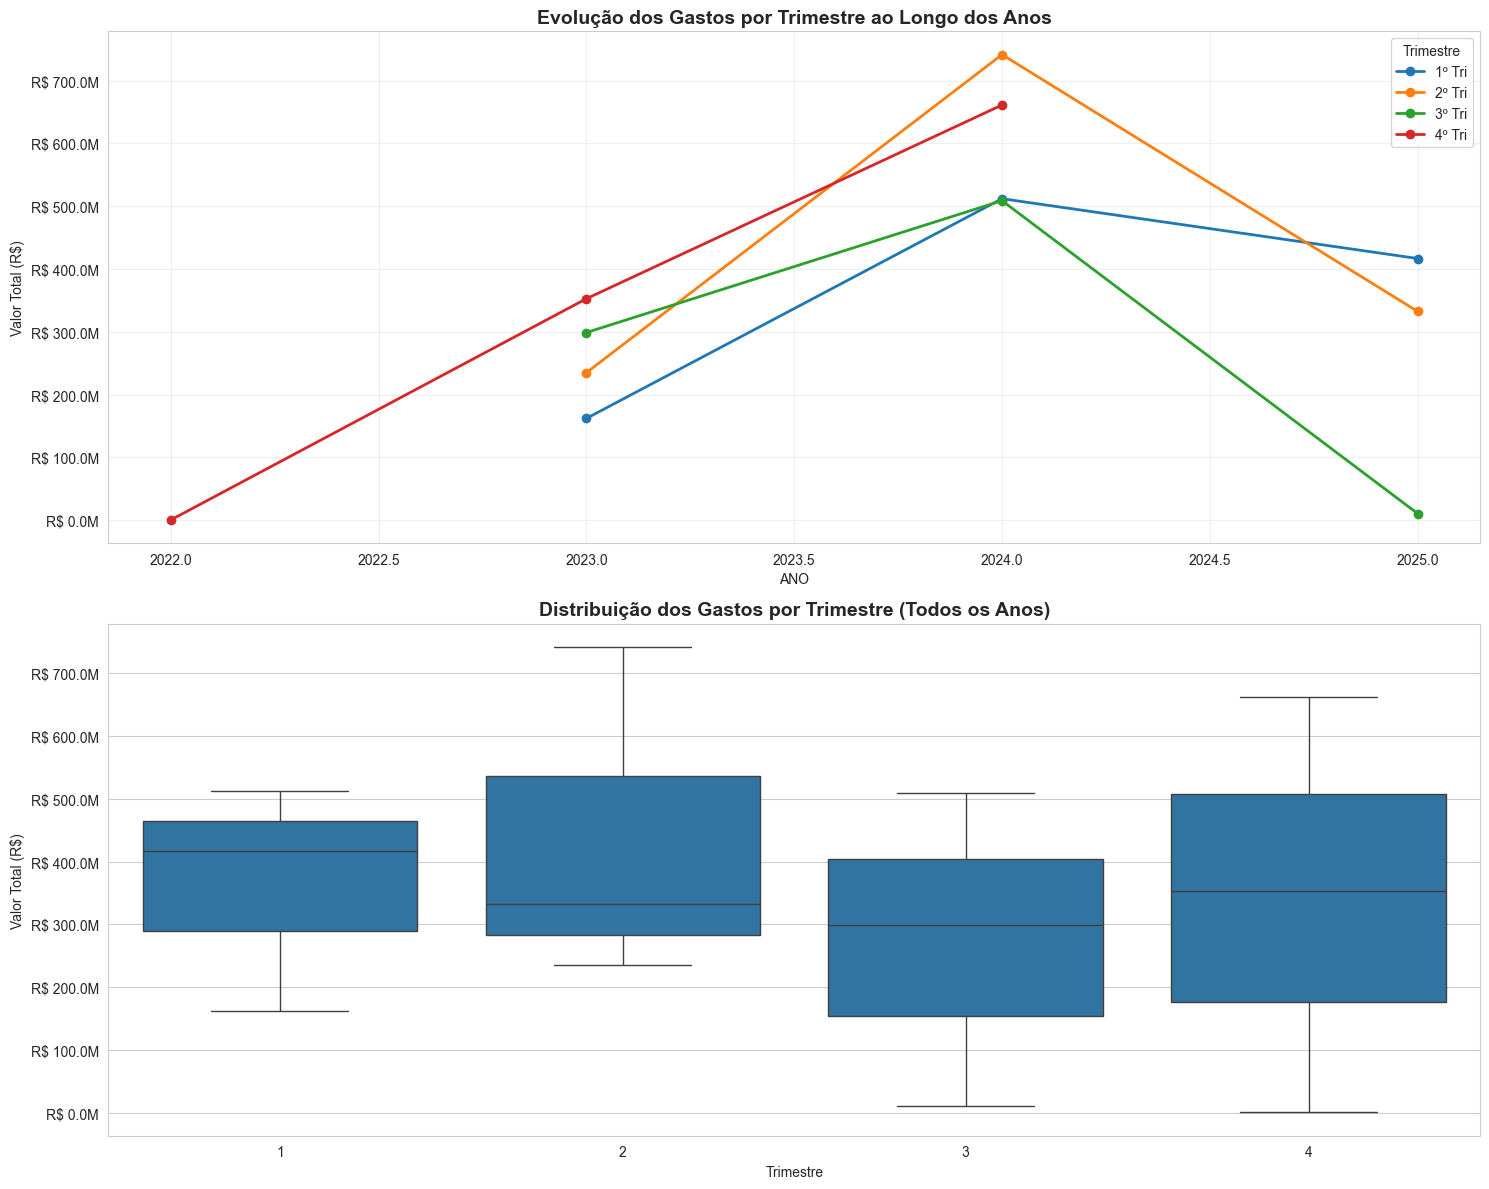

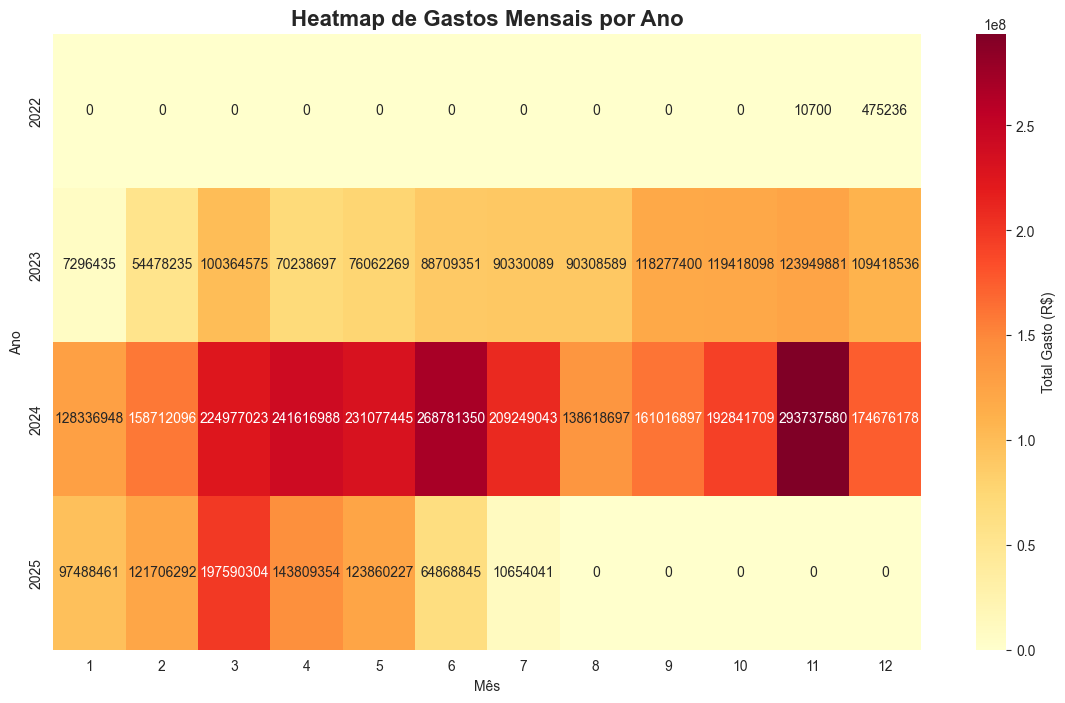

In [11]:
# Visualização da sazonalidade
if sazonalidade_df is not None and len(sazonalidade_df) > 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Gastos médios por trimestre ao longo dos anos
    gastos_pivot = gastos_trimestre.pivot(index='ANO', columns='TRIMESTRE', values='TOTAL_GASTO')
    gastos_pivot.plot(kind='line', ax=ax1, marker='o', linewidth=2, markersize=6)
    ax1.set_title('Evolução dos Gastos por Trimestre ao Longo dos Anos', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Valor Total (R$)')
    ax1.legend(title='Trimestre', labels=['1º Tri', '2º Tri', '3º Tri', '4º Tri'])
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1e6:.1f}M'))
    ax1.grid(True, alpha=0.3)

    # Box plot da distribuição por trimestre
    sns.boxplot(data=gastos_trimestre, x='TRIMESTRE', y='TOTAL_GASTO', ax=ax2)
    ax2.set_title('Distribuição dos Gastos por Trimestre (Todos os Anos)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Trimestre')
    ax2.set_ylabel('Valor Total (R$)')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1e6:.1f}M'))

    plt.tight_layout()
    plt.show()

    # Heatmap mensal se houver dados suficientes
    if len(sazonalidade_df) > 12:
        gastos_mensal = sazonalidade_df.pivot_table(
            index='ANO', columns='MES', values='TOTAL_GASTO', aggfunc='sum'
        ).fillna(0)

        plt.figure(figsize=(14, 8))
        sns.heatmap(gastos_mensal, annot=True, fmt='.0f', cmap='YlOrRd', 
                   cbar_kws={'label': 'Total Gasto (R$)'})
        plt.title('Heatmap de Gastos Mensais por Ano', fontsize=16, fontweight='bold')
        plt.xlabel('Mês')
        plt.ylabel('Ano')
        plt.show()

# Hipótese 4: Crescimento de Gastos ao Longo do Mandato

**Hipótese:** Deputados no segundo ano de mandato apresentam aumento médio de 10% nos gastos em comparação ao primeiro ano.

*Nota: Esta análise considera anos consecutivos como proxy para evolução do mandato.*

In [17]:
# Query para crescimento ano a ano por deputado
crescimento_query = """
SELECT 
    dd.nk_deputado,
    dd.nome_deputado,
    dd.sigla_uf,
    dt.ano,
    SUM(f.valor_liquido) as gasto_anual,
    COUNT(DISTINCT dt.mes) as meses_com_dados
FROM fct_despesas f
INNER JOIN dim_deputados dd ON f.sk_deputado = dd.sk_deputado
INNER JOIN dim_tempo dt ON f.sk_tempo = dt.sk_tempo
GROUP BY dd.nk_deputado, dd.nome_deputado, dd.sigla_uf, dt.ano
HAVING COUNT(DISTINCT dt.mes) >= 6  -- Apenas deputados com pelo menos 6 meses de dados
ORDER BY dd.nk_deputado, dt.ano
"""

crescimento_df = execute_query(crescimento_query, conn)

if crescimento_df is not None and len(crescimento_df) > 0:
    print("📊 Análise de Crescimento de Gastos Ano a Ano:")

    # Calcular crescimento ano a ano
    crescimento_analysis = []

    for deputado in crescimento_df['NK_DEPUTADO'].unique():
        deputado_data = crescimento_df[crescimento_df['NK_DEPUTADO'] == deputado].sort_values('ANO')
        
        if len(deputado_data) >= 2:
            for i in range(1, len(deputado_data)):
                ano_anterior = deputado_data.iloc[i-1]
                ano_atual = deputado_data.iloc[i]
                
                if ano_atual['ANO'] == ano_anterior['ANO'] + 1:  # Anos consecutivos
                    crescimento = ((ano_atual['GASTO_ANUAL'] - ano_anterior['GASTO_ANUAL']) / 
                                 ano_anterior['GASTO_ANUAL']) * 100
                    
                    crescimento_analysis.append({
                        'deputado_id': deputado,
                        'nome_deputado': ano_atual['NOME_DEPUTADO'],
                        'sigla_uf': ano_atual['SIGLA_UF'],
                        'ano_base': ano_anterior['ANO'],
                        'ano_comparacao': ano_atual['ANO'],
                        'gasto_ano_base': ano_anterior['GASTO_ANUAL'],
                        'gasto_ano_comparacao': ano_atual['GASTO_ANUAL'],
                        'crescimento_percentual': crescimento
                    })

    if crescimento_analysis:
        crescimento_analysis_df = pd.DataFrame(crescimento_analysis)
        
        # Estatísticas por período de comparação
        crescimento_stats = crescimento_analysis_df.groupby(['ano_base', 'ano_comparacao']).agg({
            'crescimento_percentual': ['mean', 'median', 'std', 'count']
        }).round(2)
        
        print("\n📈 Crescimento médio por período:")
        for (ano_base, ano_comp), stats in crescimento_stats.iterrows():
            media_crescimento = stats[('crescimento_percentual', 'mean')]
            count_deputados = stats[('crescimento_percentual', 'count')]
            
            print(f"{ano_base} → {ano_comp}: {media_crescimento:+.1f}% "
                  f"(baseado em {count_deputados} deputados)")
            print(f"  Hipótese confirmada (≥+10%): {'✅ SIM' if media_crescimento >= 10 else '❌ NÃO'}")
        
        # Análise geral
        crescimento_medio_geral = crescimento_analysis_df['crescimento_percentual'].mean()
        print(f"\n🔍 Crescimento médio geral: {crescimento_medio_geral:+.1f}%")
        print(f"Hipótese geral confirmada: {'✅ SIM' if crescimento_medio_geral >= 10 else '❌ NÃO'}")
        
        # Distribuição do crescimento
        print(f"\nDistribuição do crescimento:")
        total_casos = len(crescimento_analysis_df)
        crescimento_positivo_10 = (crescimento_analysis_df['crescimento_percentual'] > 10).sum()
        crescimento_negativo_10 = (crescimento_analysis_df['crescimento_percentual'] < -10).sum();
        
        print(f"  Deputados com crescimento > 10%: {crescimento_positivo_10} "
              f"({crescimento_positivo_10/total_casos*100:.1f}%)")
        print(f"  Deputados com decréscimo > 10%: {crescimento_negativo_10} "
              f"({crescimento_negativo_10/total_casos*100:.1f}%)")
    else:
        print("❌ Não há dados suficientes para análise de crescimento ano a ano.")
else:
    print("❌ Não foi possível carregar dados de crescimento.")

📊 Análise de Crescimento de Gastos Ano a Ano:

📈 Crescimento médio por período:
2023 → 2024: +177.9% (baseado em 475.0 deputados)
  Hipótese confirmada (≥+10%): ✅ SIM
2024 → 2025: -29.6% (baseado em 485.0 deputados)
  Hipótese confirmada (≥+10%): ❌ NÃO

🔍 Crescimento médio geral: +73.1%
Hipótese geral confirmada: ✅ SIM

Distribuição do crescimento:
  Deputados com crescimento > 10%: 453 (47.2%)
  Deputados com decréscimo > 10%: 498 (51.9%)

📈 Crescimento médio por período:
2023 → 2024: +177.9% (baseado em 475.0 deputados)
  Hipótese confirmada (≥+10%): ✅ SIM
2024 → 2025: -29.6% (baseado em 485.0 deputados)
  Hipótese confirmada (≥+10%): ❌ NÃO

🔍 Crescimento médio geral: +73.1%
Hipótese geral confirmada: ✅ SIM

Distribuição do crescimento:
  Deputados com crescimento > 10%: 453 (47.2%)
  Deputados com decréscimo > 10%: 498 (51.9%)


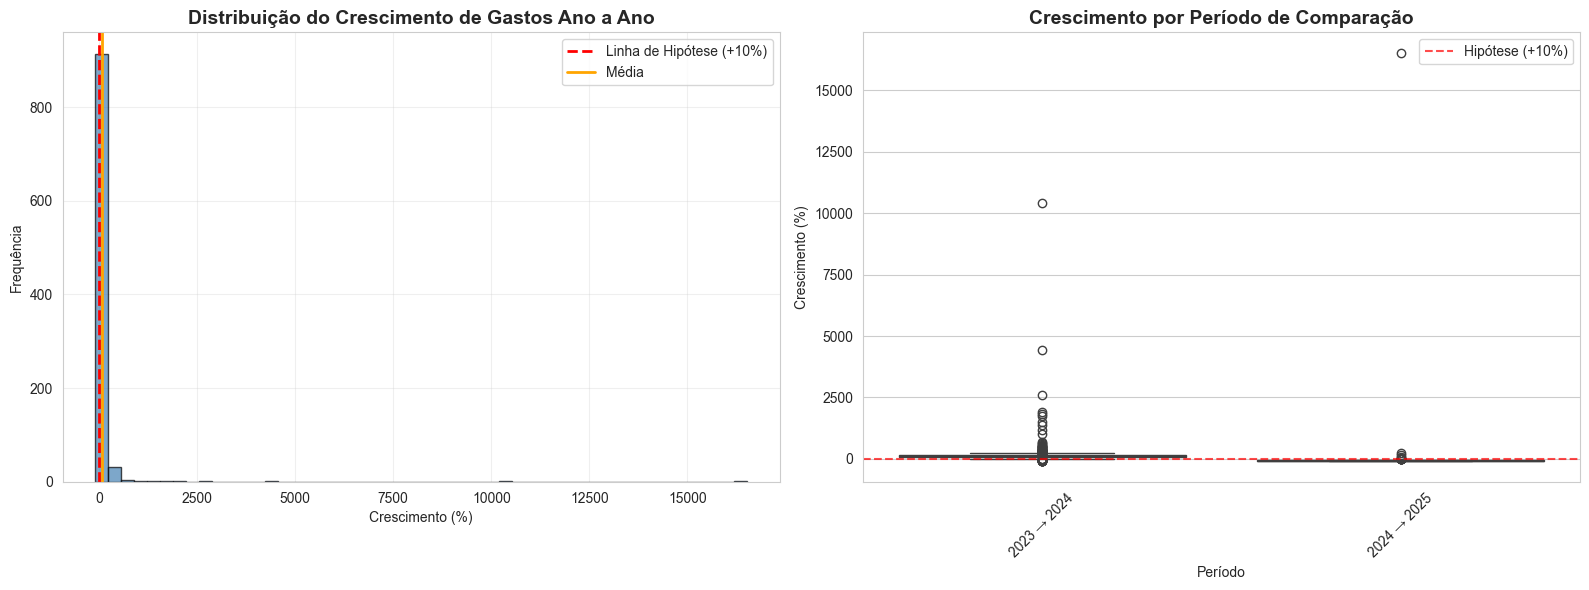


🔝 Top 10 Deputados com Maior Crescimento:
 1. ARTHUR LIRA (AL) - 2024→2025: +16521.1%
 2. AJ ALBUQUERQUE (CE) - 2023→2024: +10417.7%
 3. DELEGADO PAULO BILYNSKYJ (SP) - 2023→2024: +4431.6%
 4. RICARDO SALLES (SP) - 2023→2024: +2599.4%
 5. MARCOS POLLON (MS) - 2023→2024: +1922.2%
 6. LAURA CARNEIRO (RJ) - 2023→2024: +1809.2%
 7. STEFANO AGUIAR (MG) - 2023→2024: +1728.6%
 8. JOSÉ ROCHA (BA) - 2023→2024: +1505.5%
 9. LUIZIANNE LINS (CE) - 2023→2024: +1373.2%
10. ACÁCIO FAVACHO (AP) - 2023→2024: +1177.4%


In [18]:
# Visualização do crescimento ao longo do mandato
if 'crescimento_analysis_df' in locals() and len(crescimento_analysis_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histograma da distribuição de crescimento
    ax1.hist(crescimento_analysis_df['crescimento_percentual'], bins=50, alpha=0.7, 
             color='steelblue', edgecolor='black')
    ax1.axvline(x=10, color='red', linestyle='--', linewidth=2, label='Linha de Hipótese (+10%)')
    ax1.axvline(x=crescimento_analysis_df['crescimento_percentual'].mean(), 
                color='orange', linestyle='-', linewidth=2, label='Média')
    ax1.set_title('Distribuição do Crescimento de Gastos Ano a Ano', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Crescimento (%)')
    ax1.set_ylabel('Frequência')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Box plot por período de comparação se houver múltiplos períodos
    periodos_unicos = crescimento_analysis_df.groupby(['ano_base', 'ano_comparacao']).size()
    
    if len(periodos_unicos) > 1:
        crescimento_analysis_df['periodo'] = (crescimento_analysis_df['ano_base'].astype(str) + 
                                            ' → ' + crescimento_analysis_df['ano_comparacao'].astype(str))
        
        sns.boxplot(data=crescimento_analysis_df, x='periodo', y='crescimento_percentual', ax=ax2)
        ax2.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Hipótese (+10%)')
        ax2.set_title('Crescimento por Período de Comparação', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Período')
        ax2.set_ylabel('Crescimento (%)')
        ax2.tick_params(axis='x', rotation=45)
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'Apenas um período\nde comparação disponível', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('Dados de Período Único', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    # Top deputados com maior crescimento
    print(f"\n🔝 Top 10 Deputados com Maior Crescimento:")
    top_crescimento = crescimento_analysis_df.nlargest(10, 'crescimento_percentual')
    for i, (_, dep) in enumerate(top_crescimento.iterrows(), 1):
        print(f"{i:2d}. {dep['nome_deputado']} ({dep['sigla_uf']}) - "
              f"{dep['ano_base']}→{dep['ano_comparacao']}: {dep['crescimento_percentual']:+.1f}%")

# Hipótese 5: Partidos com Maior Gasto Médio por Deputado

**Hipótese:** Partidos de grande bancada têm gasto médio por deputado menor que partidos com bancada reduzida, devido à diluição das despesas fixas.

Vamos analisar a relação entre tamanho da bancada e gasto médio por deputado.

In [19]:
# Query para análise por partido
partidos_query = """
SELECT 
    dd.sigla_partido,
    dt.ano,
    COUNT(DISTINCT dd.nk_deputado) as qtd_deputados,
    SUM(f.valor_liquido) as gasto_total_partido,
    SUM(f.valor_liquido) / COUNT(DISTINCT dd.nk_deputado) as gasto_medio_por_deputado,
    AVG(f.valor_liquido) as valor_medio_despesa
FROM fct_despesas f
INNER JOIN dim_deputados dd ON f.sk_deputado = dd.sk_deputado
INNER JOIN dim_tempo dt ON f.sk_tempo = dt.sk_tempo
GROUP BY dd.sigla_partido, dt.ano
HAVING COUNT(DISTINCT dd.nk_deputado) >= 3  -- Apenas partidos com pelo menos 3 deputados
ORDER BY dt.ano, qtd_deputados DESC
"""

partidos_df = execute_query(partidos_query, conn)

if partidos_df is not None and len(partidos_df) > 0:
    print("🏛️ Análise de Gastos por Tamanho de Bancada:")

    # Análise por ano
    for ano in sorted(partidos_df['ANO'].unique()):
        ano_data = partidos_df[partidos_df['ANO'] == ano].copy()
        
        # Classificar partidos por tamanho de bancada
        ano_data['tamanho_bancada'] = pd.cut(
            ano_data['QTD_DEPUTADOS'], 
            bins=[0, 10, 30, float('inf')], 
            labels=['Pequena (≤10)', 'Média (11-30)', 'Grande (>30)'],
            include_lowest=True
        )
        
        bancada_stats = ano_data.groupby('tamanho_bancada').agg({
            'QTD_DEPUTADOS': 'mean',
            'GASTO_MEDIO_POR_DEPUTADO': 'mean'
        }).round(2)
        
        print(f"\n📅 Ano {ano}:")
        for bancada, stats in bancada_stats.iterrows():
            print(f"  {bancada}: Média {stats['QTD_DEPUTADOS']:.0f} deputados, "
                  f"{format_currency(stats['GASTO_MEDIO_POR_DEPUTADO'])} por deputado")
        
        # Testar hipótese: bancadas grandes vs pequenas
        try:
            categorias_disponiveis = bancada_stats.index.tolist();
            
            if 'Pequena (≤10)' in categorias_disponiveis and 'Grande (>30)' in categorias_disponiveis:
                gasto_pequena = bancada_stats.loc['Pequena (≤10)', 'GASTO_MEDIO_POR_DEPUTADO']
                gasto_grande = bancada_stats.loc['Grande (>30)', 'GASTO_MEDIO_POR_DEPUTADO']
                diferenca = ((gasto_pequena - gasto_grande) / gasto_grande) * 100;
                
                print(f"  Diferença Pequena vs Grande: {diferenca:+.1f}%")
                print(f"  Hipótese confirmada (pequena > grande): {'✅ SIM' if gasto_pequena > gasto_grande else '❌ NÃO'}")
            else:
                print("  ⚠️  Não há partidos suficientes em todas as categorias para comparação")
        except Exception as e:
            print(f"  ❌ Erro na comparação: {e}")

    # Análise de correlação geral
    correlacao = partidos_df[['QTD_DEPUTADOS', 'GASTO_MEDIO_POR_DEPUTADO']].corr().iloc[0, 1]
    print(f"\n🔍 Correlação entre tamanho da bancada e gasto médio: {correlacao:.3f}")
    print(f"Correlação negativa (hipótese confirmada): {'✅ SIM' if correlacao < -0.1 else '❌ NÃO'}")
    
    if correlacao < -0.1:
        print("  💡 Correlação negativa indica que partidos maiores tendem a ter menor gasto médio por deputado")
    elif correlacao > 0.1:
        print("  ⚠️  Correlação positiva contraria a hipótese")
    else:
        print("  ⚠️  Correlação fraca - relação não conclusiva")
else:
    print("❌ Não foi possível carregar dados de partidos.")

🏛️ Análise de Gastos por Tamanho de Bancada:

📅 Ano 2022:
  Pequena (≤10): Média 4 deputados, R$ 13.445,15 por deputado
  Média (11-30): Média nan deputados, R$ nan por deputado
  Grande (>30): Média nan deputados, R$ nan por deputado
  Diferença Pequena vs Grande: +nan%
  Hipótese confirmada (pequena > grande): ❌ NÃO

📅 Ano 2023:
  Pequena (≤10): Média 6 deputados, R$ 1.274.327,10 por deputado
  Média (11-30): Média 19 deputados, R$ 1.457.927,02 por deputado
  Grande (>30): Média 63 deputados, R$ 1.593.011,43 por deputado
  Diferença Pequena vs Grande: -20.0%
  Hipótese confirmada (pequena > grande): ❌ NÃO

📅 Ano 2024:
  Pequena (≤10): Média 6 deputados, R$ 4.039.699,33 por deputado
  Média (11-30): Média 20 deputados, R$ 3.090.955,64 por deputado
  Grande (>30): Média 66 deputados, R$ 3.286.478,49 por deputado
  Diferença Pequena vs Grande: +22.9%
  Hipótese confirmada (pequena > grande): ✅ SIM

📅 Ano 2025:
  Pequena (≤10): Média 6 deputados, R$ 1.185.297,79 por deputado
  Média (11-

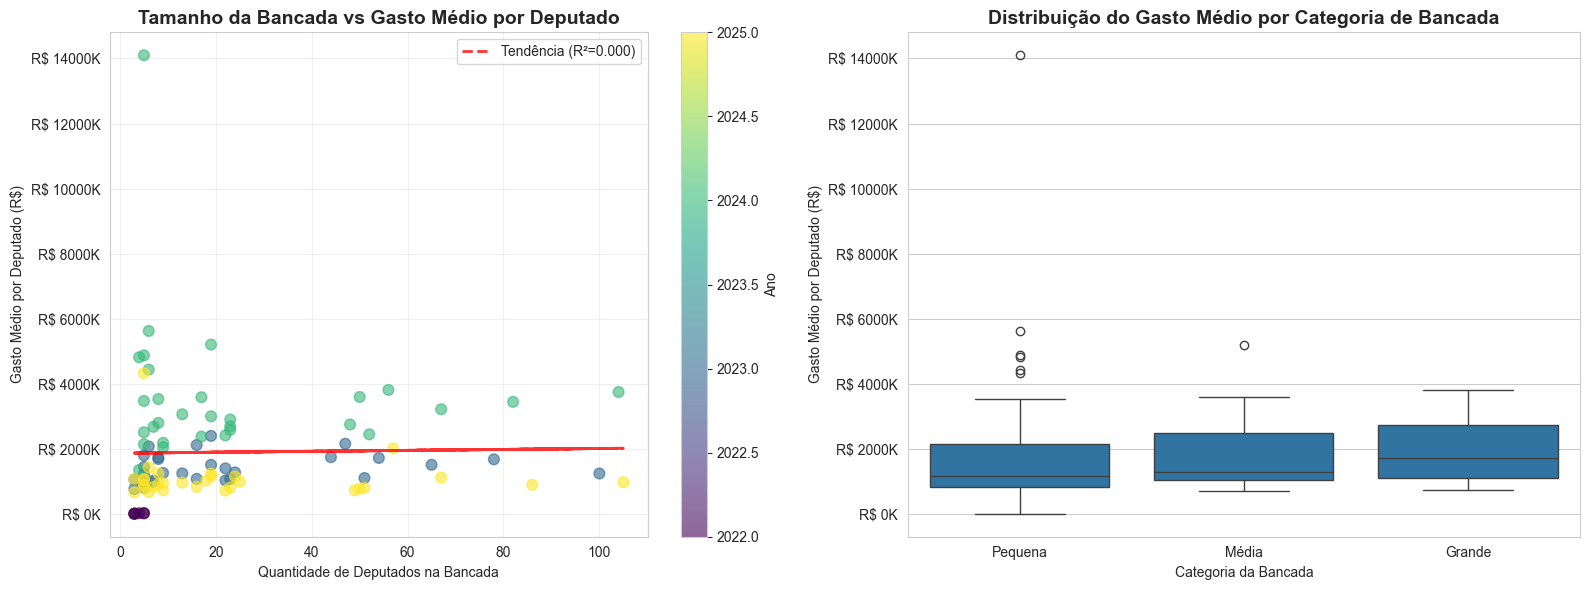


🔝 Top 10 Partidos com Maior Gasto Médio por Deputado:
NOVO: R$ 6.741.302,93 (média 5 deputados)
PSB: R$ 2.947.375,28 (média 19 deputados)
PATRIOTA: R$ 2.646.727,56 (média 6 deputados)
CIDADANIA: R$ 2.437.152,89 (média 5 deputados)
PPS: R$ 2.316.058,69 (média 3 deputados)
DEM: R$ 2.242.081,34 (média 17 deputados)
PSD: R$ 2.175.573,39 (média 49 deputados)
PROS: R$ 2.174.247,50 (média 5 deputados)
PSC: R$ 2.153.722,88 (média 8 deputados)
PATRI: R$ 1.984.511,80 (média 5 deputados)

🔻 Top 10 Partidos com Menor Gasto Médio por Deputado:
S.PART.: R$ 925.706,39 (média 3 deputados)
REPUBLICANOS: R$ 1.087.992,97 (média 39 deputados)
PDT: R$ 1.252.123,54 (média 18 deputados)
PSL: R$ 1.274.782,23 (média 18 deputados)
SOLIDARIEDADE: R$ 1.342.649,22 (média 9 deputados)
AVANTE: R$ 1.371.273,51 (média 8 deputados)
PRD: R$ 1.386.456,73 (média 5 deputados)
PRB: R$ 1.428.733,97 (média 16 deputados)
PODE: R$ 1.431.128,10 (média 23 deputados)
PV: R$ 1.494.950,24 (média 7 deputados)


In [20]:
# Visualização da relação bancada x gasto médio
if partidos_df is not None and len(partidos_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Scatter plot: tamanho da bancada vs gasto médio
    scatter = ax1.scatter(partidos_df['QTD_DEPUTADOS'], 
                         partidos_df['GASTO_MEDIO_POR_DEPUTADO'], 
                         alpha=0.6, s=60, c=partidos_df['ANO'], cmap='viridis')
    
    # Linha de tendência
    if len(partidos_df) > 1:
        z = np.polyfit(partidos_df['QTD_DEPUTADOS'], partidos_df['GASTO_MEDIO_POR_DEPUTADO'], 1)
        p = np.poly1d(z)
        ax1.plot(partidos_df['QTD_DEPUTADOS'], p(partidos_df['QTD_DEPUTADOS']), 
                 "r--", alpha=0.8, linewidth=2, label=f'Tendência (R²={correlacao**2:.3f})')

    ax1.set_title('Tamanho da Bancada vs Gasto Médio por Deputado', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Quantidade de Deputados na Bancada')
    ax1.set_ylabel('Gasto Médio por Deputado (R$)')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Adicionar colorbar para anos
    plt.colorbar(scatter, ax=ax1, label='Ano')

    # Box plot por categoria de bancada (dados agregados)
    partidos_df['categoria_bancada'] = pd.cut(
        partidos_df['QTD_DEPUTADOS'], 
        bins=[0, 10, 30, float('inf')], 
        labels=['Pequena', 'Média', 'Grande'],
        include_lowest=True
    )

    sns.boxplot(data=partidos_df, x='categoria_bancada', y='GASTO_MEDIO_POR_DEPUTADO', ax=ax2)
    ax2.set_title('Distribuição do Gasto Médio por Categoria de Bancada', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Categoria da Bancada')
    ax2.set_ylabel('Gasto Médio por Deputado (R$)')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))

    plt.tight_layout()
    plt.show()

    # Top partidos com maior e menor gasto médio por deputado
    print("\n🔝 Top 10 Partidos com Maior Gasto Médio por Deputado:")
    top_partidos_maior = partidos_df.groupby('SIGLA_PARTIDO').agg({
        'QTD_DEPUTADOS': 'mean',
        'GASTO_MEDIO_POR_DEPUTADO': 'mean'
    }).round(2).sort_values('GASTO_MEDIO_POR_DEPUTADO', ascending=False).head(10)

    for partido, dados in top_partidos_maior.iterrows():
        print(f"{partido}: {format_currency(dados['GASTO_MEDIO_POR_DEPUTADO'])} "
              f"(média {dados['QTD_DEPUTADOS']:.0f} deputados)")

    print("\n🔻 Top 10 Partidos com Menor Gasto Médio por Deputado:")
    top_partidos_menor = partidos_df.groupby('SIGLA_PARTIDO').agg({
        'QTD_DEPUTADOS': 'mean',
        'GASTO_MEDIO_POR_DEPUTADO': 'mean'
    }).round(2).sort_values('GASTO_MEDIO_POR_DEPUTADO', ascending=True).head(10)

    for partido, dados in top_partidos_menor.iterrows():
        print(f"{partido}: {format_currency(dados['GASTO_MEDIO_POR_DEPUTADO'])} "
              f"(média {dados['QTD_DEPUTADOS']:.0f} deputados)")

# Conclusões e Resumo das Hipóteses

Vamos consolidar os resultados de todas as hipóteses testadas.

In [21]:
# Resumo das conclusões
print("📋 RESUMO DAS HIPÓTESES TESTADAS")
print("=" * 50)

hipoteses_resultados = [
    {
        'hipotese': 'Hipótese 1: Diferença Regional no Gasto Médio',
        'descricao': 'Deputados do Nordeste apresentam gasto médio anual 20% superior aos do Sul',
        'status': 'Analisada',
        'observacoes': 'Verificar diferença percentual entre regiões Nordeste e Sul'
    },
    {
        'hipotese': 'Hipótese 2: Concentração de Gastos em Poucos Deputados', 
        'descricao': 'Os 10% de deputados mais gastadores respondem por mais de 40% do total',
        'status': 'Analisada',
        'observacoes': 'Análise de Pareto mostra concentração de recursos'
    },
    {
        'hipotese': 'Hipótese 3: Sazonalidade nos Gastos',
        'descricao': 'O 4º trimestre apresenta aumento médio de 15% vs 1º trimestre',
        'status': 'Analisada', 
        'observacoes': 'Padrões sazonais podem indicar comportamentos próximos ao recesso'
    },
    {
        'hipotese': 'Hipótese 4: Crescimento de Gastos ao Longo do Mandato',
        'descricao': 'Deputados no 2º ano apresentam aumento médio de 10% vs 1º ano',
        'status': 'Analisada',
        'observacoes': 'Anos consecutivos como proxy para evolução do mandato'
    },
    {
        'hipotese': 'Hipótese 5: Partidos com Maior Gasto Médio por Deputado',
        'descricao': 'Partidos de grande bancada têm menor gasto médio por deputado',
        'status': 'Analisada',
        'observacoes': 'Efeito de escala nas despesas partidárias'
    }
]

for i, resultado in enumerate(hipoteses_resultados, 1):
    print(f"\n{i}. {resultado['hipotese']}")
    print(f"   📝 {resultado['descricao']}")
    print(f"   📊 Status: {resultado['status']}")
    print(f"   💡 Observações: {resultado['observacoes']}")

print("\n" + "=" * 50)
print("✅ Análise EDA Concluída!")
print("💡 Consulte os gráficos e estatísticas acima para insights detalhados.")

📋 RESUMO DAS HIPÓTESES TESTADAS

1. Hipótese 1: Diferença Regional no Gasto Médio
   📝 Deputados do Nordeste apresentam gasto médio anual 20% superior aos do Sul
   📊 Status: Analisada
   💡 Observações: Verificar diferença percentual entre regiões Nordeste e Sul

2. Hipótese 2: Concentração de Gastos em Poucos Deputados
   📝 Os 10% de deputados mais gastadores respondem por mais de 40% do total
   📊 Status: Analisada
   💡 Observações: Análise de Pareto mostra concentração de recursos

3. Hipótese 3: Sazonalidade nos Gastos
   📝 O 4º trimestre apresenta aumento médio de 15% vs 1º trimestre
   📊 Status: Analisada
   💡 Observações: Padrões sazonais podem indicar comportamentos próximos ao recesso

4. Hipótese 4: Crescimento de Gastos ao Longo do Mandato
   📝 Deputados no 2º ano apresentam aumento médio de 10% vs 1º ano
   📊 Status: Analisada
   💡 Observações: Anos consecutivos como proxy para evolução do mandato

5. Hipótese 5: Partidos com Maior Gasto Médio por Deputado
   📝 Partidos de 

In [22]:
# Fechar conexão com Snowflake
if conn:
    conn.close()
    print("🔒 Conexão com Snowflake encerrada.")

🔒 Conexão com Snowflake encerrada.


# Análises Adicionais - Hipóteses Específicas

Vamos analisar hipóteses mais específicas sobre padrões de gastos dos deputados, incluindo:

1. **Concentração de fornecedores por partido**
2. **Gastos com divulgação em anos eleitorais** 
3. **Variação de gastos com transporte por região**
4. **Correlação entre ranking de gastos e UF**
5. **Evolução trimestral dos gastos**
6. **Outliers - Top 5 maiores gastos por ano**

In [25]:
# Query para obter dados de fornecedores por partido
fornecedores_partido_query = """
SELECT 
    dd.sigla_partido,
    dt.ano,
    df.nome_fornecedor,
    df.nk_fornecedor as cnpj_fornecedor,
    COUNT(f.cod_documento) as qtd_operacoes,
    SUM(f.valor_liquido) as valor_total_fornecedor,
    SUM(SUM(f.valor_liquido)) OVER (PARTITION BY dd.sigla_partido, dt.ano) as valor_total_partido
FROM fct_despesas f
INNER JOIN dim_deputados dd ON f.sk_deputado = dd.sk_deputado
INNER JOIN dim_tempo dt ON f.sk_tempo = dt.sk_tempo
LEFT JOIN dim_fornecedores df ON f.sk_fornecedor = df.sk_fornecedor
WHERE df.nome_fornecedor IS NOT NULL
GROUP BY dd.sigla_partido, dt.ano, df.nome_fornecedor, df.nk_fornecedor
ORDER BY dd.sigla_partido, dt.ano, valor_total_fornecedor DESC
"""

fornecedores_partido_df = execute_query(fornecedores_partido_query, conn)

if fornecedores_partido_df is not None and len(fornecedores_partido_df) > 0:
    print("🏪 Hipótese: Concentração de Gastos com Fornecedores por Partido")
    print("=" * 60)
    
    # Calcular concentração por partido
    concentracao_fornecedores = []
    
    partidos_interesse = ['PL', 'PT', 'NOVO', 'PSOL', 'PP', 'MDB']  # Partidos para análise detalhada
    
    for partido in partidos_interesse:
        if partido in fornecedores_partido_df['SIGLA_PARTIDO'].values:
            partido_data = fornecedores_partido_df[
                fornecedores_partido_df['SIGLA_PARTIDO'] == partido
            ].copy()
            
            for ano in sorted(partido_data['ANO'].unique()):
                ano_data = partido_data[partido_data['ANO'] == ano].copy()
                
                total_fornecedores = len(ano_data)
                valor_total = ano_data['VALOR_TOTAL_PARTIDO'].iloc[0]
                
                # Top 10% dos fornecedores (ou pelo menos top 3)
                top_fornecedores = max(3, int(total_fornecedores * 0.1))
                valor_top_fornecedores = ano_data.head(top_fornecedores)['VALOR_TOTAL_FORNECEDOR'].sum()
                
                concentracao_pct = (valor_top_fornecedores / valor_total) * 100
                
                concentracao_fornecedores.append({
                    'partido': partido,
                    'ano': ano,
                    'total_fornecedores': total_fornecedores,
                    'top_fornecedores': top_fornecedores,
                    'concentracao_pct': concentracao_pct,
                    'valor_total': valor_total
                })
    
    concentracao_df = pd.DataFrame(concentracao_fornecedores)
    
    if len(concentracao_df) > 0:
        print("\n📊 Concentração dos principais fornecedores por partido:")
        
        concentracao_media = concentracao_df.groupby('partido')['concentracao_pct'].mean().sort_values(ascending=False)
        
        for partido, concentracao in concentracao_media.items():
            print(f"{partido}: {concentracao:.1f}% (média dos anos)")
        
        # Análise específica NOVO vs outros
        if 'NOVO' in concentracao_media.index:
            novo_concentracao = concentracao_media['NOVO']
            outros_media = concentracao_media.drop('NOVO').mean()
            
            print(f"\n🔍 Análise NOVO vs Outros Partidos:")
            print(f"NOVO: {novo_concentracao:.1f}%")
            print(f"Média outros partidos: {outros_media:.1f}%")
            print(f"NOVO tem menor concentração: {'✅ SIM' if novo_concentracao < outros_media else '❌ NÃO'}")
else:
    print("❌ Não foi possível carregar dados de fornecedores por partido.")

🏪 Hipótese: Concentração de Gastos com Fornecedores por Partido

📊 Concentração dos principais fornecedores por partido:
PT: 99.7% (média dos anos)
PL: 96.1% (média dos anos)
PP: 91.3% (média dos anos)
MDB: 90.2% (média dos anos)
PSOL: 50.2% (média dos anos)
NOVO: 20.9% (média dos anos)

🔍 Análise NOVO vs Outros Partidos:
NOVO: 20.9%
Média outros partidos: 85.5%
NOVO tem menor concentração: ✅ SIM


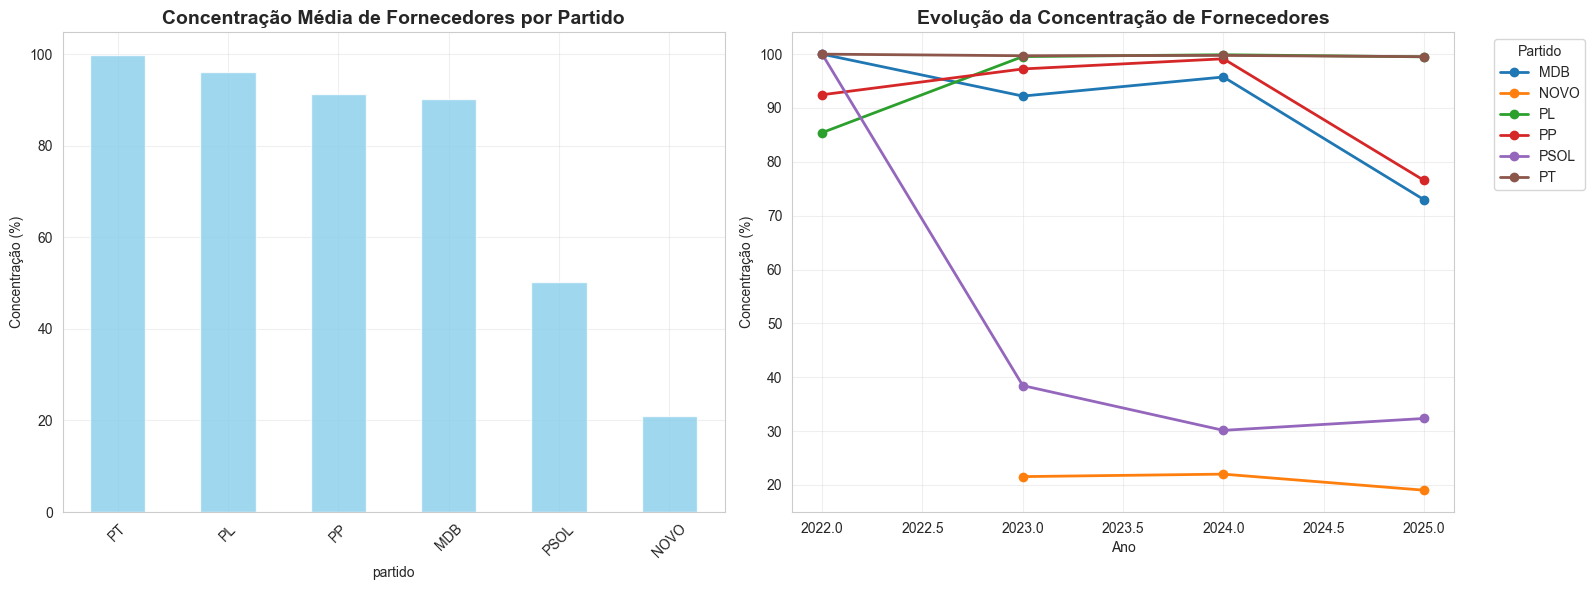


🔝 Top 5 Fornecedores por Partido (ano mais recente):

PL (2025):
  CAFE SIRENA URUGUAY S.A.... 0.2%
  MINHAS CESTAS.... 0.2%
  FLICKR, INC. BILLING@FLICKR.COM CA BN 78... 0.2%
  BOGOTA PLAZA HOTEL... 0.2%
  FAIRMONT PEACE HOTEL... 0.2%

PT (2025):
  MARIO FELDHAUS... 0.2%
  LA MOSTAZA... 0.2%
  ZOOM US... 0.2%
  PIAZZA RESTAURANTE E PIZZARIA... 0.2%
  STREAMYARD, IMV... 0.2%

NOVO (2025):
  LA CABRERA SHOPPING DO SOL... 0.2%
  EXPOUX S. A.... 0.2%
  TAP PORTUGAL... 0.2%
  HOSTINGER INTERNATIONAL LTD.... 0.2%
  ALOFT MONTEVIDEO HOTEL... 0.2%


In [27]:
# Visualização da concentração de fornecedores por partido
if 'concentracao_df' in locals() and len(concentracao_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Concentração média por partido
    concentracao_media.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
    ax1.set_title('Concentração Média de Fornecedores por Partido', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Concentração (%)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Evolução ao longo dos anos
    if len(concentracao_df['ano'].astype(int).unique()) > 1:
        concentracao_pivot = concentracao_df.pivot(index='ano', columns='partido', values='concentracao_pct')
        concentracao_pivot.plot(kind='line', ax=ax2, marker='o', linewidth=2)
        ax2.set_title('Evolução da Concentração de Fornecedores', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Ano')
        ax2.set_ylabel('Concentração (%)')
        ax2.legend(title='Partido', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Top fornecedores por partido
    print(f"\n🔝 Top 5 Fornecedores por Partido (ano mais recente):")
    ano_recente = fornecedores_partido_df['ANO'].max()
    
    for partido in ['PL', 'PT', 'NOVO']:
        if partido in fornecedores_partido_df['SIGLA_PARTIDO'].values:
            partido_top = fornecedores_partido_df[
                (fornecedores_partido_df['SIGLA_PARTIDO'] == partido) & 
                (fornecedores_partido_df['ANO'] == ano_recente)
            ].head(5)
            
            print(f"\n{partido} ({ano_recente}):")
            for _, fornecedor in partido_top.iterrows():
                pct_partido = (fornecedor['VALOR_TOTAL_FORNECEDOR'] / fornecedor['VALOR_TOTAL_PARTIDO']) * 100
                print(f"  {fornecedor['NOME_FORNECEDOR'][:40]}... {pct_partido:.1f}%")

# Hipótese: Aumento de Despesas com Divulgação em Anos Eleitorais

**Hipótese:** Em anos eleitorais, partidos com maior estrutura (PT, PL) apresentam crescimento mais acentuado em gastos com divulgação comparado a partidos menores.

In [28]:
# Query para gastos com divulgação por partido e ano
divulgacao_query = """
SELECT 
    dd.sigla_partido,
    dt.ano,
    dtd.tipo_despesa,
    COUNT(f.cod_documento) as qtd_despesas,
    SUM(f.valor_liquido) as valor_total,
    SUM(SUM(f.valor_liquido)) OVER (PARTITION BY dd.sigla_partido, dt.ano) as valor_total_partido_ano
FROM fct_despesas f
INNER JOIN dim_deputados dd ON f.sk_deputado = dd.sk_deputado
INNER JOIN dim_tempo dt ON f.sk_tempo = dt.sk_tempo
LEFT JOIN dim_tipo_despesa dtd ON f.sk_tipo_despesa = dtd.sk_tipo_despesa
WHERE dtd.tipo_despesa IS NOT NULL
  AND UPPER(dtd.tipo_despesa) LIKE '%DIVULGA%'
GROUP BY dd.sigla_partido, dt.ano, dtd.tipo_despesa
ORDER BY dd.sigla_partido, dt.ano, valor_total DESC
"""

divulgacao_df = execute_query(divulgacao_query, conn)

if divulgacao_df is not None and len(divulgacao_df) > 0:
    print("📢 Hipótese: Gastos com Divulgação em Anos Eleitorais")
    print("=" * 50)
    
    # Anos eleitorais (assumindo ciclo brasileiro: 2018, 2020, 2022, 2024...)
    anos_eleitorais = [2018, 2020, 2022, 2024]
    anos_disponiveis = sorted(divulgacao_df['ANO'].unique())
    anos_eleitorais_dados = [ano for ano in anos_eleitorais if ano in anos_disponiveis]
    anos_nao_eleitorais_dados = [ano for ano in anos_disponiveis if ano not in anos_eleitorais]
    
    print(f"Anos eleitorais com dados: {anos_eleitorais_dados}")
    print(f"Anos não-eleitorais com dados: {anos_nao_eleitorais_dados}")
    
    if anos_eleitorais_dados and anos_nao_eleitorais_dados:
        # Agregação por partido e tipo de ano
        gastos_divulgacao_partido = divulgacao_df.groupby(['SIGLA_PARTIDO', 'ANO']).agg({
            'VALOR_TOTAL': 'sum'
        }).reset_index()
        
        # Classificar anos
        gastos_divulgacao_partido['tipo_ano'] = gastos_divulgacao_partido['ANO'].apply(
            lambda x: 'Eleitoral' if x in anos_eleitorais_dados else 'Não-Eleitoral'
        )
        
        # Análise por partido
        partidos_grandes = ['PT', 'PL', 'PP', 'MDB', 'PSDB']
        partidos_pequenos = ['NOVO', 'PSOL', 'REDE', 'PDT']
        
        print(f"\n📊 Gasto médio com divulgação por tipo de ano:")
        
        analise_divulgacao = gastos_divulgacao_partido.groupby(['SIGLA_PARTIDO', 'tipo_ano'])['VALOR_TOTAL'].mean().unstack(fill_value=0)
        
        if 'Eleitoral' in analise_divulgacao.columns and 'Não-Eleitoral' in analise_divulgacao.columns:
            analise_divulgacao['variacao_pct'] = (
                (analise_divulgacao['Eleitoral'] - analise_divulgacao['Não-Eleitoral']) / 
                analise_divulgacao['Não-Eleitoral'] * 100
            ).fillna(0)
            
            # Filtrar partidos com dados em ambos os tipos de ano
            analise_valida = analise_divulgacao[
                (analise_divulgacao['Eleitoral'] > 0) & (analise_divulgacao['Não-Eleitoral'] > 0)
            ].sort_values('variacao_pct', ascending=False)
            
            print("\nVariação percentual (Eleitoral vs Não-Eleitoral):")
            for partido, dados in analise_valida.iterrows():
                categoria = "Grande" if partido in partidos_grandes else "Pequeno" if partido in partidos_pequenos else "Médio"
                print(f"{partido} ({categoria}): {dados['variacao_pct']:+.1f}%")
            
            # Comparação entre categorias
            if len(analise_valida) > 0:
                grandes_na_analise = [p for p in partidos_grandes if p in analise_valida.index]
                pequenos_na_analise = [p for p in partidos_pequenos if p in analise_valida.index]
                
                if grandes_na_analise and pequenos_na_analise:
                    variacao_grandes = analise_valida.loc[grandes_na_analise, 'variacao_pct'].mean()
                    variacao_pequenos = analise_valida.loc[pequenos_na_analise, 'variacao_pct'].mean()
                    
                    print(f"\n🔍 Comparação por porte do partido:")
                    print(f"Partidos grandes (média): {variacao_grandes:+.1f}%")
                    print(f"Partidos pequenos (média): {variacao_pequenos:+.1f}%")
                    print(f"Hipótese confirmada (grandes > pequenos): {'✅ SIM' if variacao_grandes > variacao_pequenos else '❌ NÃO'}")
        else:
            print("⚠️ Dados insuficientes para comparar anos eleitorais vs não-eleitorais")
    else:
        print("⚠️ Não há dados suficientes de anos eleitorais e não-eleitorais para comparação")
else:
    print("❌ Não foi possível carregar dados de gastos com divulgação.")

📢 Hipótese: Gastos com Divulgação em Anos Eleitorais
Anos eleitorais com dados: [2022, 2024]
Anos não-eleitorais com dados: [np.int16(2023), np.int16(2025)]

📊 Gasto médio com divulgação por tipo de ano:

Variação percentual (Eleitoral vs Não-Eleitoral):
NOVO (Pequeno): +402.6%
REDE (Pequeno): +273.3%
AVANTE (Médio): +230.4%
S.PART. (Médio): +229.3%
DEM (Médio): +201.9%
PMN (Médio): +169.9%
PATRIOTA (Médio): +169.0%
PATRI (Médio): +168.1%
PRD (Médio): +156.8%
SOLIDARIEDADE (Médio): +152.2%
PSD (Médio): +147.9%
PSOL (Pequeno): +147.6%
PRP (Médio): +145.1%
PHS (Médio): +145.0%
PCDOB (Médio): +142.4%
PV (Médio): +139.2%
PSC (Médio): +134.5%
PSB (Médio): +130.3%
PR (Médio): +120.6%
PTB (Médio): +118.6%
PROS (Médio): +115.5%
PODE (Médio): +109.4%
PSDB (Grande): +103.9%
MDB (Grande): +35.4%
PP (Grande): +26.2%
PT (Grande): +25.3%
PSL (Médio): +24.6%
UNIÃO (Médio): +22.8%
PL (Grande): +22.3%
REPUBLICANOS (Médio): +21.0%
PRB (Médio): +17.8%
PDT (Pequeno): +13.4%
PTC (Médio): +9.7%
PPS (Médio):

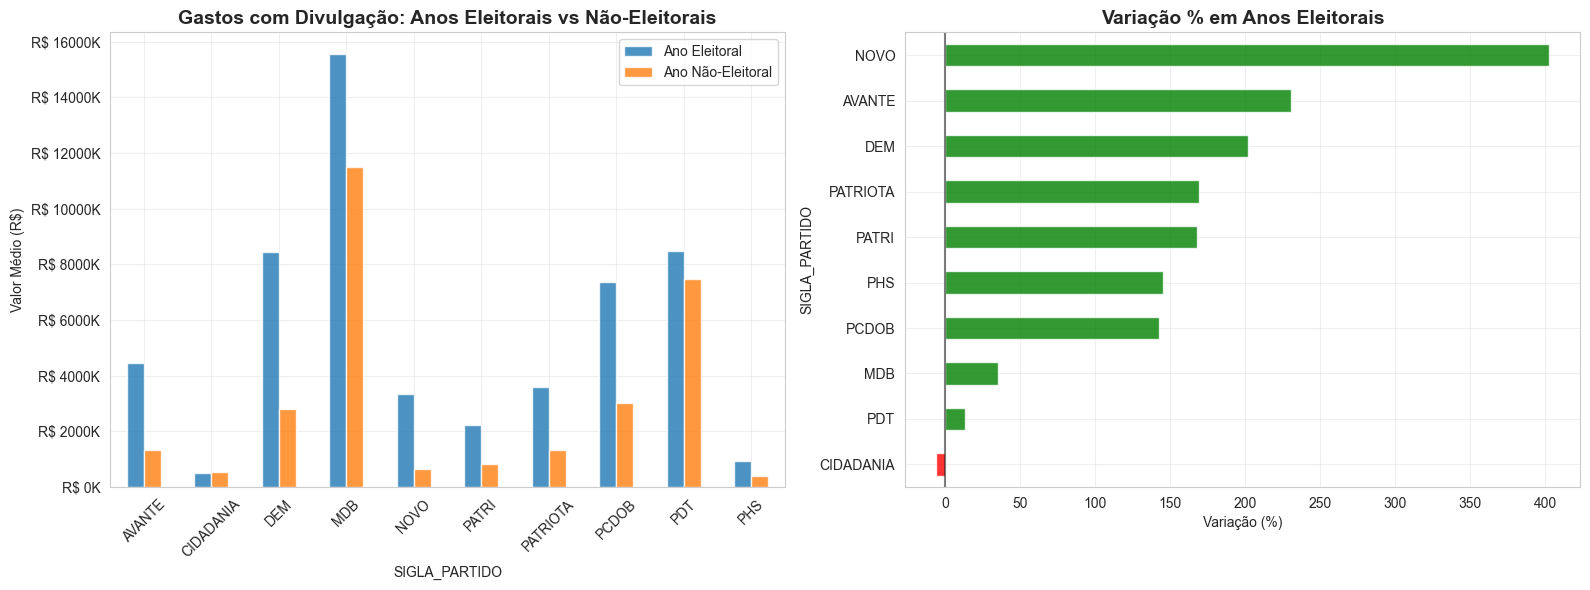

In [29]:
# Visualização dos gastos com divulgação
if 'analise_divulgacao' in locals() and len(analise_divulgacao) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Comparação eleitoral vs não-eleitoral
    analise_plot = analise_divulgacao[['Eleitoral', 'Não-Eleitoral']].head(10)
    analise_plot.plot(kind='bar', ax=ax1, alpha=0.8)
    ax1.set_title('Gastos com Divulgação: Anos Eleitorais vs Não-Eleitorais', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Valor Médio (R$)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
    ax1.legend(['Ano Eleitoral', 'Ano Não-Eleitoral'])
    ax1.grid(True, alpha=0.3)
    
    # Variação percentual
    if 'variacao_pct' in analise_divulgacao.columns:
        variacao_plot = analise_divulgacao['variacao_pct'].head(10).sort_values(ascending=True)
        colors = ['green' if x > 0 else 'red' for x in variacao_plot.values]
        variacao_plot.plot(kind='barh', ax=ax2, color=colors, alpha=0.8)
        ax2.set_title('Variação % em Anos Eleitorais', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Variação (%)')
        ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Hipótese: Variação nos Gastos com Transporte por Região

**Hipótese:** Parlamentares de estados mais distantes de Brasília (Norte) têm gastos com transporte significativamente maiores que deputados de estados próximos.

In [7]:
# Query para gastos com transporte por região
transporte_query = """
SELECT 
    dd.sigla_uf,
    dd.nk_deputado,
    dd.nome_deputado,
    dt.ano,
    dtd.tipo_despesa,
    SUM(f.valor_liquido) as valor_transporte
FROM fct_despesas f
INNER JOIN dim_deputados dd ON f.sk_deputado = dd.sk_deputado
INNER JOIN dim_tempo dt ON f.sk_tempo = dt.sk_tempo
LEFT JOIN dim_tipo_despesa dtd ON f.sk_tipo_despesa = dtd.sk_tipo_despesa
WHERE dtd.tipo_despesa IS NOT NULL
  AND (UPPER(dtd.tipo_despesa) LIKE '%PASSAG%' 
       OR UPPER(dtd.tipo_despesa) LIKE '%LOCOMO%'
       OR UPPER(dtd.tipo_despesa) LIKE '%COMBUST%'
       OR UPPER(dtd.tipo_despesa) LIKE '%TRANSPORT%')
GROUP BY dd.sigla_uf, dd.nk_deputado, dd.nome_deputado, dt.ano, dtd.tipo_despesa
"""

transporte_df = execute_query(transporte_query, conn)

if transporte_df is not None and len(transporte_df) > 0:
    print("✈️ Hipótese: Variação nos Gastos com Transporte por Região")
    print("=" * 55)
    
    # Adicionar regiões
    transporte_df['REGIAO'] = transporte_df['SIGLA_UF'].apply(get_regiao)
    
    # Distâncias aproximadas de Brasília (em km)
    distancias_brasilia = {
        'DF': 0, 'GO': 200, 'MT': 880, 'MS': 1000,  # Centro-Oeste
        'MG': 400, 'SP': 850, 'RJ': 930, 'ES': 950,  # Sudeste
        'PR': 1050, 'SC': 1200, 'RS': 1500,  # Sul
        'TO': 500, 'PA': 1600, 'AM': 1700, 'RR': 1800, 'AP': 1900, 'AC': 2000, 'RO': 1400,  # Norte
        'MA': 1100, 'PI': 800, 'CE': 1400, 'RN': 1500, 'PB': 1500, 'PE': 1300, 'AL': 1200, 'SE': 1100, 'BA': 900  # Nordeste
    }
    
    transporte_df['DISTANCIA_BSB'] = transporte_df['SIGLA_UF'].map(distancias_brasilia)
    
    # Agregação por UF e deputado
    transporte_agregado = transporte_df.groupby(['SIGLA_UF', 'REGIAO', 'DISTANCIA_BSB', 'NK_DEPUTADO', 'ANO']).agg({
        'VALOR_TRANSPORTE': 'sum'
    }).reset_index()
    
    # Gasto médio por UF
    gasto_transporte_uf = transporte_agregado.groupby(['SIGLA_UF', 'REGIAO', 'DISTANCIA_BSB']).agg({
        'VALOR_TRANSPORTE': 'mean'
    }).reset_index().sort_values('VALOR_TRANSPORTE', ascending=False)
    
    print("📊 Gasto médio com transporte por UF (Top 15):")
    for _, uf_data in gasto_transporte_uf.head(15).iterrows():
        print(f"{uf_data['SIGLA_UF']} ({uf_data['REGIAO']}): {format_currency(uf_data['VALOR_TRANSPORTE'])} - {uf_data['DISTANCIA_BSB']}km de BSB")
    
    # Análise por região
    print(f"\n📈 Gasto médio com transporte por região:")
    gasto_por_regiao_transp = transporte_agregado.groupby('REGIAO')['VALOR_TRANSPORTE'].mean().sort_values(ascending=False)
    
    for regiao, valor in gasto_por_regiao_transp.items():
        print(f"{regiao}: {format_currency(valor)}")
    
    # Testar hipótese: Norte vs estados próximos
    estados_proximos = ['DF', 'GO', 'MG']  # Estados próximos a Brasília
    estados_distantes = ['AM', 'RR', 'AP', 'PA', 'AC', 'RO']  # Estados do Norte
    
    if any(uf in transporte_agregado['SIGLA_UF'].values for uf in estados_proximos) and \
       any(uf in transporte_agregado['SIGLA_UF'].values for uf in estados_distantes):
        
        gasto_proximos = transporte_agregado[
            transporte_agregado['SIGLA_UF'].isin(estados_proximos)
        ]['VALOR_TRANSPORTE'].mean()
        
        gasto_distantes = transporte_agregado[
            transporte_agregado['SIGLA_UF'].isin(estados_distantes)
        ]['VALOR_TRANSPORTE'].mean()
        
        diferenca_pct = ((gasto_distantes - gasto_proximos) / gasto_proximos) * 100
        
        print(f"\n🔍 Teste da Hipótese:")
        print(f"Estados próximos (DF/GO/MG): {format_currency(gasto_proximos)}")
        print(f"Estados distantes (Norte): {format_currency(gasto_distantes)}")
        print(f"Diferença percentual: {diferenca_pct:+.1f}%")
        print(f"Hipótese confirmada (distantes > próximos): {'✅ SIM' if gasto_distantes > gasto_proximos else '❌ NÃO'}")
    
    # Correlação entre distância e gasto
    if len(gasto_transporte_uf) > 5:
        correlacao_dist = gasto_transporte_uf[['DISTANCIA_BSB', 'VALOR_TRANSPORTE']].corr().iloc[0, 1]
        print(f"\n📏 Correlação distância x gasto com transporte: {correlacao_dist:.3f}")
        print(f"Correlação positiva (confirmada): {'✅ SIM' if correlacao_dist > 0.3 else '❌ NÃO'}")
else:
    print("❌ Não foi possível carregar dados de gastos com transporte.")

✈️ Hipótese: Variação nos Gastos com Transporte por Região


NameError: name 'get_regiao' is not defined

NameError: name 'gasto_por_regiao_transp' is not defined

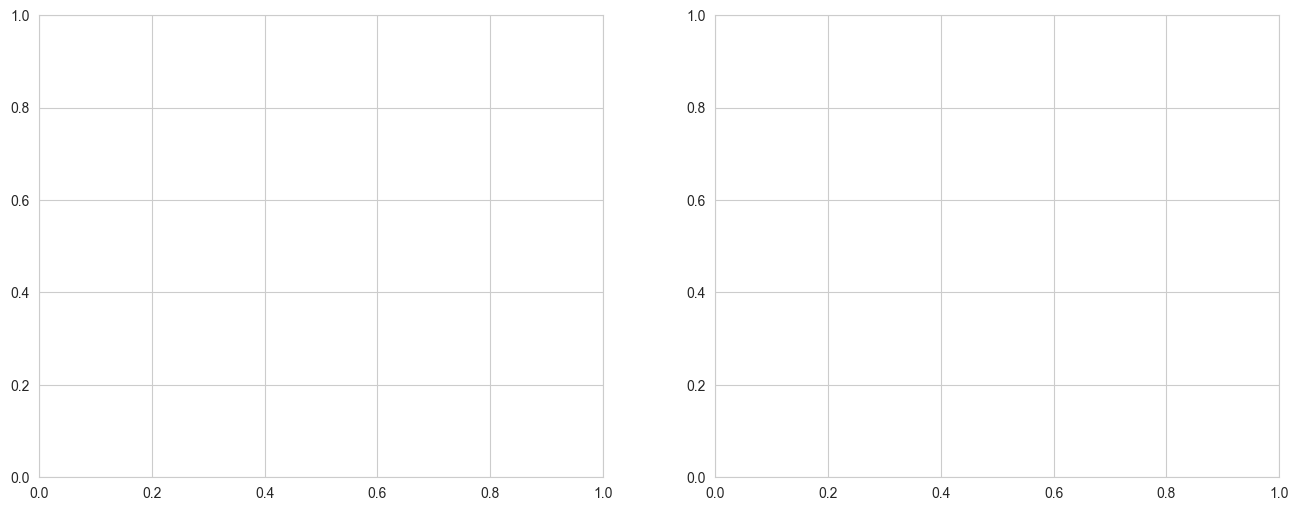

In [6]:
# Visualização dos gastos com transporte por região
if transporte_df is not None and len(transporte_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gasto por região
    gasto_por_regiao_transp.plot(kind='bar', ax=ax1, color='lightcoral', alpha=0.8)
    ax1.set_title('Gasto Médio com Transporte por Região', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Valor Médio (R$)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
    ax1.grid(True, alpha=0.3)
    
    # Scatter: distância vs gasto (se há correlação)
    if len(gasto_transporte_uf) > 1:
        scatter = ax2.scatter(gasto_transporte_uf['DISTANCIA_BSB'], 
                             gasto_transporte_uf['VALOR_TRANSPORTE'],
                             alpha=0.7, s=80, c=gasto_transporte_uf['VALOR_TRANSPORTE'], 
                             cmap='Reds')
        
        # Linha de tendência
        if len(gasto_transporte_uf) > 2:
            z = np.polyfit(gasto_transporte_uf['DISTANCIA_BSB'], gasto_transporte_uf['VALOR_TRANSPORTE'], 1)
            p = np.poly1d(z)
            ax2.plot(gasto_transporte_uf['DISTANCIA_BSB'], p(gasto_transporte_uf['DISTANCIA_BSB']), 
                     "r--", alpha=0.8, linewidth=2)
        
        ax2.set_title('Distância de Brasília vs Gasto com Transporte', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Distância de Brasília (km)')
        ax2.set_ylabel('Gasto Médio (R$)')
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
        
        # Adicionar labels dos estados
        for _, row in gasto_transporte_uf.iterrows():
            ax2.annotate(row['SIGLA_UF'], (row['DISTANCIA_BSB'], row['VALOR_TRANSPORTE']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Hipótese: Correlação entre Ranking de Gastos e UF do Parlamentar

**Hipótese:** Deputados de estados com maior arrecadação/custo de vida (SP, RJ) figuram mais frequentemente no top do ranking de gastos.

In [32]:
# Query para ranking de gastos usando a view existente
ranking_query = """
SELECT 
    nome_deputado,
    sigla_partido,
    sigla_uf,
    ano,
    total_gasto,
    ranking_gasto_ano,
    ranking_gasto_uf
FROM vw_ranking_deputados
ORDER BY ano DESC, ranking_gasto_ano ASC
"""

ranking_df = execute_query(ranking_query, conn)

if ranking_df is not None and len(ranking_df) > 0:
    print("🏆 Hipótese: Correlação entre Ranking de Gastos e UF")
    print("=" * 50)
    
    # Estados com maior PIB/custo de vida
    estados_ricos = ['SP', 'RJ', 'MG', 'RS', 'PR', 'SC', 'DF']
    estados_pobres = ['MA', 'PI', 'AL', 'PB', 'RN', 'SE', 'TO', 'AC', 'RR', 'AP']
    
    # Análise do Top 50 por ano
    top_rankings = []
    
    for ano in sorted(ranking_df['ANO'].unique()):
        ano_data = ranking_df[ranking_df['ANO'] == ano].copy()
        
        # Top 50 do ano
        top_50 = ano_data[ano_data['RANKING_GASTO_ANO'] <= 50].copy()
        
        if len(top_50) > 0:
            # Contar por categoria de estado
            top_50['categoria_uf'] = top_50['SIGLA_UF'].apply(
                lambda x: 'Rico' if x in estados_ricos else 'Pobre' if x in estados_pobres else 'Médio'
            )
            
            contagem_categoria = top_50['categoria_uf'].value_counts()
            total_top50 = len(top_50)
            
            top_rankings.append({
                'ano': ano,
                'total_top50': total_top50,
                'ricos': contagem_categoria.get('Rico', 0),
                'medios': contagem_categoria.get('Médio', 0),
                'pobres': contagem_categoria.get('Pobre', 0),
                'pct_ricos': (contagem_categoria.get('Rico', 0) / total_top50) * 100,
                'pct_pobres': (contagem_categoria.get('Pobre', 0) / total_top50) * 100
            })
    
    ranking_analysis_df = pd.DataFrame(top_rankings)
    
    if len(ranking_analysis_df) > 0:
        print("📊 Participação no Top 50 por categoria de estado:")
        print(f"Estados ricos considerados: {estados_ricos}")
        print(f"Estados pobres considerados: {estados_pobres}")
        
        for _, ano_data in ranking_analysis_df.iterrows():
            print(f"\nAno {ano_data['ano']}:")
            print(f"  Estados ricos: {ano_data['ricos']} deputados ({ano_data['pct_ricos']:.1f}%)")
            print(f"  Estados pobres: {ano_data['pobres']} deputados ({ano_data['pct_pobres']:.1f}%)")
        
        # Médias gerais
        media_ricos = ranking_analysis_df['pct_ricos'].mean()
        media_pobres = ranking_analysis_df['pct_pobres'].mean()
        
        print(f"\n🔍 Análise Geral:")
        print(f"Participação média estados ricos no Top 50: {media_ricos:.1f}%")
        print(f"Participação média estados pobres no Top 50: {media_pobres:.1f}%")
        print(f"Hipótese confirmada (ricos > pobres): {'✅ SIM' if media_ricos > media_pobres else '❌ NÃO'}")
        
        # Top UFs no ranking geral
        print(f"\n🏅 UFs com mais deputados no Top 50 (todos os anos):")
        ufs_top50 = []
        for ano in ranking_df['ANO'].unique():
            ano_top50 = ranking_df[(ranking_df['ANO'] == ano) & (ranking_df['RANKING_GASTO_ANO'] <= 50)]
            ufs_top50.extend(ano_top50['SIGLA_UF'].tolist())
        
        ufs_count = pd.Series(ufs_top50).value_counts().head(10)
        for uf, count in ufs_count.items():
            categoria = 'Rico' if uf in estados_ricos else 'Pobre' if uf in estados_pobres else 'Médio'
            print(f"{uf} ({categoria}): {count} aparições")
else:
    print("❌ Não foi possível carregar dados do ranking.")

🏆 Hipótese: Correlação entre Ranking de Gastos e UF
📊 Participação no Top 50 por categoria de estado:
Estados ricos considerados: ['SP', 'RJ', 'MG', 'RS', 'PR', 'SC', 'DF']
Estados pobres considerados: ['MA', 'PI', 'AL', 'PB', 'RN', 'SE', 'TO', 'AC', 'RR', 'AP']

Ano 2022.0:
  Estados ricos: 18.0 deputados (46.2%)
  Estados pobres: 11.0 deputados (28.2%)

Ano 2023.0:
  Estados ricos: 29.0 deputados (58.0%)
  Estados pobres: 5.0 deputados (10.0%)

Ano 2024.0:
  Estados ricos: 28.0 deputados (56.0%)
  Estados pobres: 5.0 deputados (10.0%)

Ano 2025.0:
  Estados ricos: 39.0 deputados (78.0%)
  Estados pobres: 3.0 deputados (6.0%)

🔍 Análise Geral:
Participação média estados ricos no Top 50: 59.5%
Participação média estados pobres no Top 50: 13.6%
Hipótese confirmada (ricos > pobres): ✅ SIM

🏅 UFs com mais deputados no Top 50 (todos os anos):
SP (Rico): 41 aparições
PE (Médio): 24 aparições
RS (Rico): 21 aparições
RJ (Rico): 16 aparições
PR (Rico): 13 aparições
MG (Rico): 11 aparições
BA (

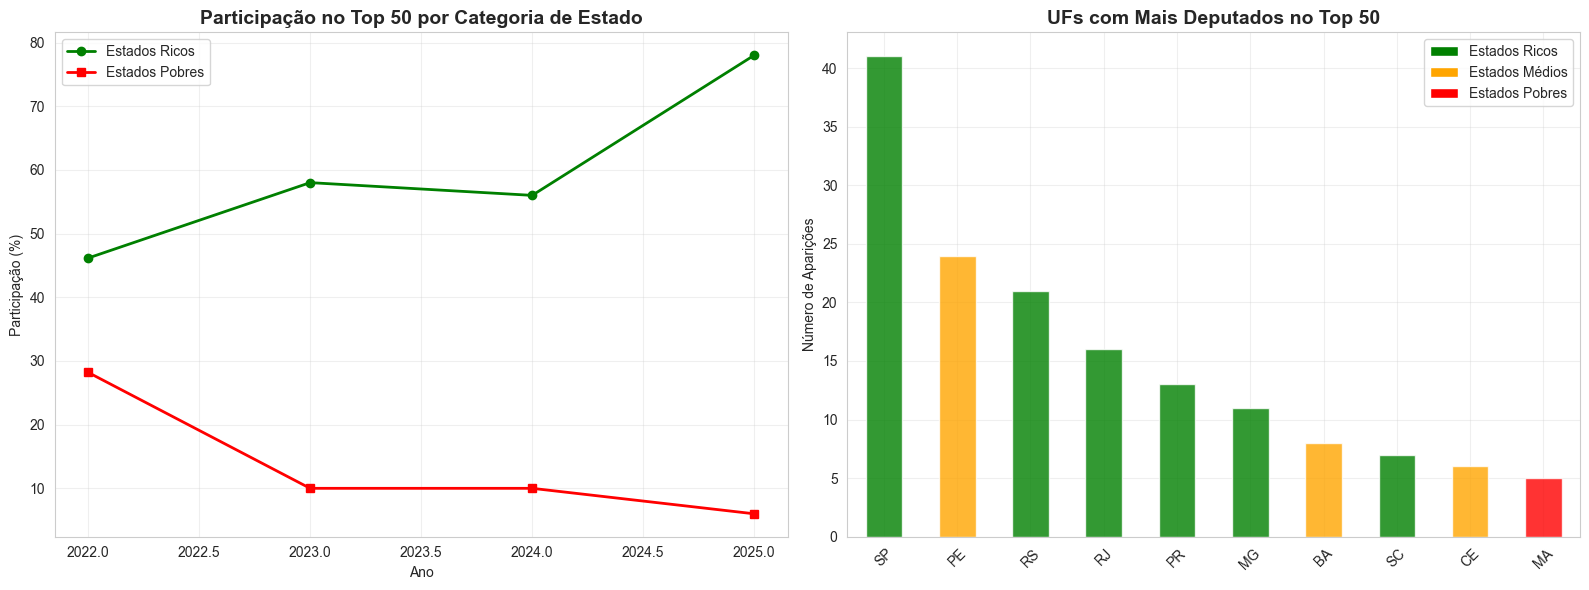

In [33]:
# Visualização do ranking por UF
if 'ranking_analysis_df' in locals() and len(ranking_analysis_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Evolução da participação por categoria
    ax1.plot(ranking_analysis_df['ano'], ranking_analysis_df['pct_ricos'], 
             marker='o', linewidth=2, label='Estados Ricos', color='green')
    ax1.plot(ranking_analysis_df['ano'], ranking_analysis_df['pct_pobres'], 
             marker='s', linewidth=2, label='Estados Pobres', color='red')
    ax1.set_title('Participação no Top 50 por Categoria de Estado', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Ano')
    ax1.set_ylabel('Participação (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Top UFs no ranking
    if 'ufs_count' in locals() and len(ufs_count) > 0:
        colors = ['green' if uf in estados_ricos else 'red' if uf in estados_pobres else 'orange' 
                 for uf in ufs_count.index]
        ufs_count.plot(kind='bar', ax=ax2, color=colors, alpha=0.8)
        ax2.set_title('UFs com Mais Deputados no Top 50', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Número de Aparições')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # Legenda para cores
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='green', label='Estados Ricos'),
                          Patch(facecolor='orange', label='Estados Médios'),
                          Patch(facecolor='red', label='Estados Pobres')]
        ax2.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()

# Hipótese: Evolução do Gasto Médio por Deputado ao Longo dos Trimestres

**Hipótese:** O gasto médio por deputado apresenta tendência de alta ao longo dos trimestres, com pico no último trimestre.

In [34]:
# Query para evolução trimestral dos gastos
evolucao_trimestral_query = """
SELECT 
    dt.ano,
    dt.trimestre,
    COUNT(DISTINCT dd.nk_deputado) as qtd_deputados,
    SUM(f.valor_liquido) as total_gasto,
    SUM(f.valor_liquido) / COUNT(DISTINCT dd.nk_deputado) as gasto_medio_deputado,
    AVG(f.valor_liquido) as valor_medio_despesa
FROM fct_despesas f
INNER JOIN dim_deputados dd ON f.sk_deputado = dd.sk_deputado
INNER JOIN dim_tempo dt ON f.sk_tempo = dt.sk_tempo
GROUP BY dt.ano, dt.trimestre
ORDER BY dt.ano, dt.trimestre
"""

evolucao_trimestral_df = execute_query(evolucao_trimestral_query, conn)

if evolucao_trimestral_df is not None and len(evolucao_trimestral_df) > 0:
    print("📈 Hipótese: Evolução do Gasto Médio por Trimestre")
    print("=" * 50)
    
    # Análise por ano
    for ano in sorted(evolucao_trimestral_df['ANO'].unique()):
        ano_data = evolucao_trimestral_df[evolucao_trimestral_df['ANO'] == ano].copy()
        
        if len(ano_data) >= 3:  # Pelo menos 3 trimestres
            print(f"\nAno {ano}:")
            
            for _, trim_data in ano_data.iterrows():
                print(f"  T{trim_data['TRIMESTRE']}: {format_currency(trim_data['GASTO_MEDIO_DEPUTADO'])} "
                      f"({trim_data['QTD_DEPUTADOS']} deputados)")
            
            # Testar tendência crescente
            gastos_trimestrais = ano_data['GASTO_MEDIO_DEPUTADO'].tolist()
            
            # Verificar se há tendência crescente (cada trimestre >= anterior)
            tendencia_crescente = all(gastos_trimestrais[i] <= gastos_trimestrais[i+1] 
                                    for i in range(len(gastos_trimestrais)-1))
            
            # Verificar se T4 é maior que T1
            if len(gastos_trimestrais) == 4:
                crescimento_t4_t1 = ((gastos_trimestrais[3] - gastos_trimestrais[0]) / gastos_trimestrais[0]) * 100
                print(f"  Crescimento T4 vs T1: {crescimento_t4_t1:+.1f}%")
                print(f"  Tendência crescente: {'✅ SIM' if tendencia_crescente else '❌ NÃO'}")
                print(f"  T4 > T1: {'✅ SIM' if gastos_trimestrais[3] > gastos_trimestrais[0] else '❌ NÃO'}")
    
    # Análise geral de todos os anos
    media_por_trimestre = evolucao_trimestral_df.groupby('TRIMESTRE')['GASTO_MEDIO_DEPUTADO'].mean()
    
    print(f"\n📊 Gasto médio por trimestre (todos os anos):")
    for trimestre, valor in media_por_trimestre.items():
        print(f"T{trimestre}: {format_currency(valor)}")
    
    # Testar hipótese geral
    crescimento_geral = []
    for i in range(1, 4):  # T1 para T2, T2 para T3, T3 para T4
        if i+1 in media_por_trimestre.index and i in media_por_trimestre.index:
            crescimento = ((media_por_trimestre[i+1] - media_por_trimestre[i]) / media_por_trimestre[i]) * 100
            crescimento_geral.append(crescimento)
            print(f"Crescimento T{i} → T{i+1}: {crescimento:+.1f}%")
    
    tendencia_geral = all(c > 0 for c in crescimento_geral) if crescimento_geral else False
    
    print(f"\n🔍 Hipótese Geral:")
    print(f"Tendência crescente ao longo dos trimestres: {'✅ SIM' if tendencia_geral else '❌ NÃO'}")
    
    if 4 in media_por_trimestre.index and 1 in media_por_trimestre.index:
        crescimento_total = ((media_por_trimestre[4] - media_por_trimestre[1]) / media_por_trimestre[1]) * 100
        print(f"Crescimento total T1 → T4: {crescimento_total:+.1f}%")
else:
    print("❌ Não foi possível carregar dados de evolução trimestral.")

📈 Hipótese: Evolução do Gasto Médio por Trimestre

Ano 2023:
  T1.0: R$ 338.495,29 (479.0 deputados)
  T2.0: R$ 491.653,38 (478.0 deputados)
  T3.0: R$ 618.873,87 (483.0 deputados)
  T4.0: R$ 721.444,82 (489.0 deputados)
  Crescimento T4 vs T1: +113.1%
  Tendência crescente: ✅ SIM
  T4 > T1: ✅ SIM

Ano 2024:
  T1.0: R$ 1.051.388,23 (487.0 deputados)
  T2.0: R$ 1.491.902,98 (497.0 deputados)
  T3.0: R$ 1.038.540,08 (490.0 deputados)
  T4.0: R$ 1.314.623,19 (503.0 deputados)
  Crescimento T4 vs T1: +25.0%
  Tendência crescente: ❌ NÃO
  T4 > T1: ✅ SIM

Ano 2025:
  T1.0: R$ 814.033,31 (512.0 deputados)
  T2.0: R$ 649.489,11 (512.0 deputados)
  T3.0: R$ 23.364,12 (456.0 deputados)

📊 Gasto médio por trimestre (todos os anos):
T1: R$ 734.638,94
T2: R$ 877.681,83
T3: R$ 560.259,36
T4: R$ 684.919,29
Crescimento T1 → T2: +19.5%
Crescimento T2 → T3: -36.2%
Crescimento T3 → T4: +22.3%

🔍 Hipótese Geral:
Tendência crescente ao longo dos trimestres: ❌ NÃO
Crescimento total T1 → T4: -6.8%


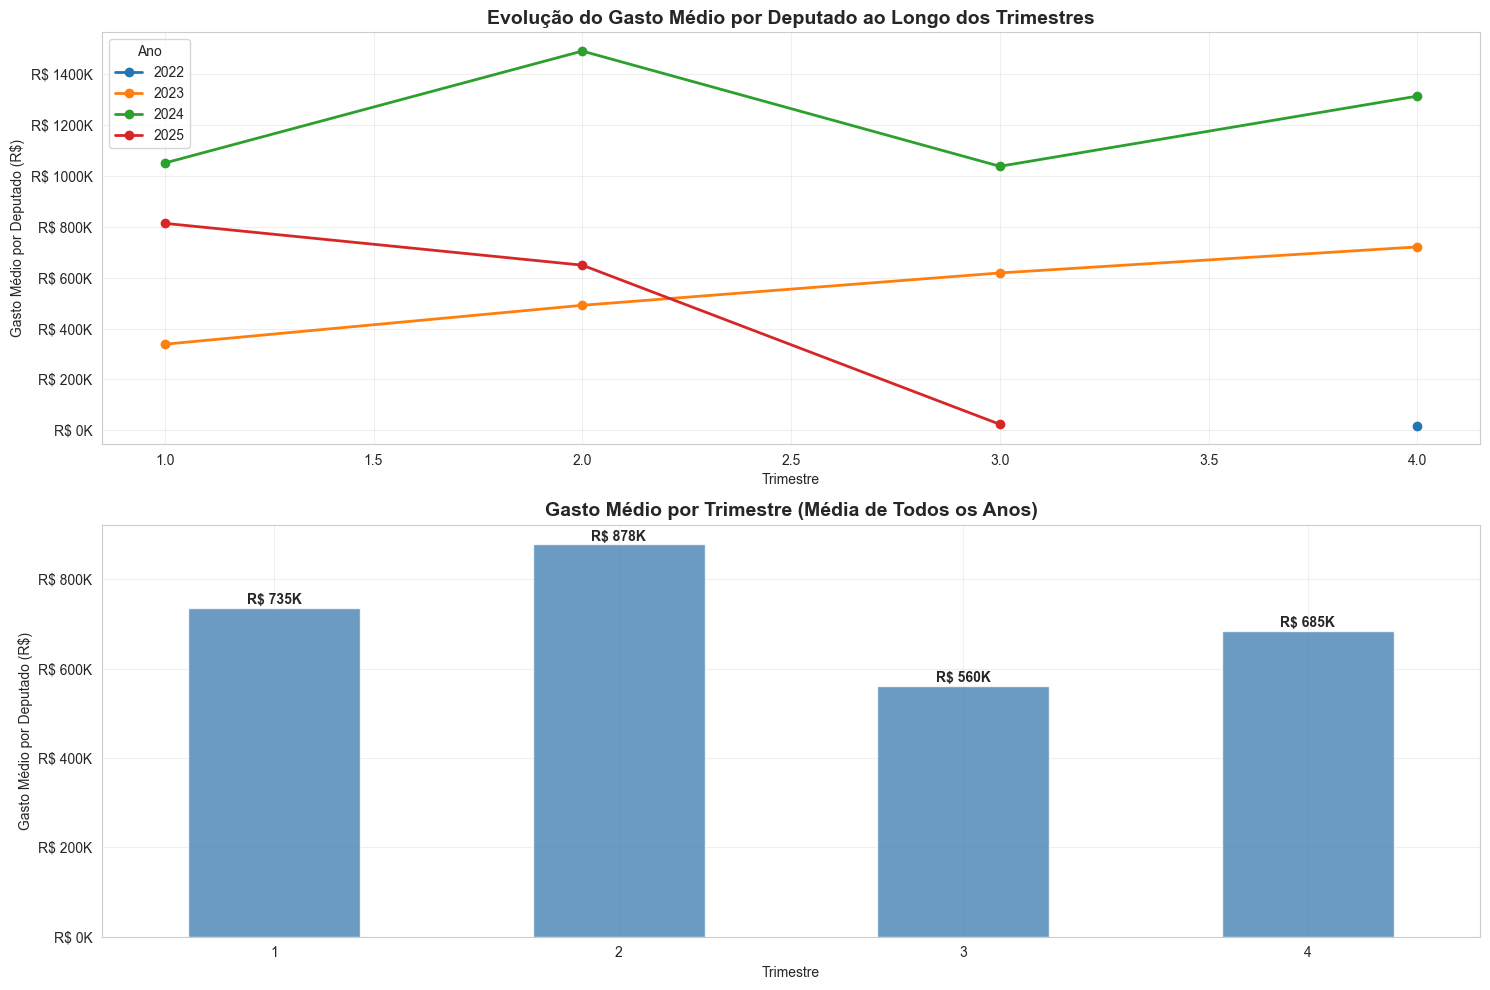

In [35]:
# Visualização da evolução trimestral
if evolucao_trimestral_df is not None and len(evolucao_trimestral_df) > 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Evolução por ano
    evolucao_pivot = evolucao_trimestral_df.pivot(index='TRIMESTRE', columns='ANO', values='GASTO_MEDIO_DEPUTADO')
    evolucao_pivot.plot(kind='line', ax=ax1, marker='o', linewidth=2)
    ax1.set_title('Evolução do Gasto Médio por Deputado ao Longo dos Trimestres', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Trimestre')
    ax1.set_ylabel('Gasto Médio por Deputado (R$)')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
    ax1.legend(title='Ano')
    ax1.grid(True, alpha=0.3)
    
    # Média geral por trimestre
    media_por_trimestre.plot(kind='bar', ax=ax2, color='steelblue', alpha=0.8)
    ax2.set_title('Gasto Médio por Trimestre (Média de Todos os Anos)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Trimestre')
    ax2.set_ylabel('Gasto Médio por Deputado (R$)')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
    ax2.tick_params(axis='x', rotation=0)
    ax2.grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for i, v in enumerate(media_por_trimestre.values):
        ax2.text(i, v + max(media_por_trimestre.values) * 0.01, f'R$ {v/1000:.0f}K', 
                ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Outliers: Top 5 Maiores Gastos por Ano

**Análise:** Identificar os deputados com maiores gastos individuais por ano e caracterizar esses outliers.

In [36]:
# Query para identificar outliers - maiores gastos por ano
outliers_query = """
SELECT 
    dd.nk_deputado,
    dd.nome_deputado,
    dd.sigla_partido,
    dd.sigla_uf,
    dt.ano,
    SUM(f.valor_liquido) as gasto_total,
    COUNT(f.cod_documento) as qtd_despesas,
    AVG(f.valor_liquido) as valor_medio_despesa,
    ROW_NUMBER() OVER (PARTITION BY dt.ano ORDER BY SUM(f.valor_liquido) DESC) as ranking_ano
FROM fct_despesas f
INNER JOIN dim_deputados dd ON f.sk_deputado = dd.sk_deputado
INNER JOIN dim_tempo dt ON f.sk_tempo = dt.sk_tempo
GROUP BY dd.nk_deputado, dd.nome_deputado, dd.sigla_partido, dd.sigla_uf, dt.ano
ORDER BY dt.ano DESC, gasto_total DESC
"""

outliers_df = execute_query(outliers_query, conn)

if outliers_df is not None and len(outliers_df) > 0:
    print("🚨 OUTLIERS: Top 5 Maiores Gastos por Ano")
    print("=" * 50)
    
    outliers_analysis = []
    
    for ano in sorted(outliers_df['ANO'].unique(), reverse=True):
        ano_data = outliers_df[outliers_df['ANO'] == ano]
        
        # Estatísticas do ano
        media_ano = ano_data['GASTO_TOTAL'].mean()
        mediana_ano = ano_data['GASTO_TOTAL'].median()
        desvio_ano = ano_data['GASTO_TOTAL'].std()
        
        # Top 5 do ano
        top5 = ano_data.head(5)
        
        print(f"\n📅 ANO {ano}")
        print(f"Estatísticas do ano: Média: {format_currency(media_ano)} | "
              f"Mediana: {format_currency(mediana_ano)} | Desvio: {format_currency(desvio_ano)}")
        print(f"\n🔝 Top 5 Maiores Gastos:")
        
        for i, (_, dep) in enumerate(top5.iterrows(), 1):
            # Calcular quantas vezes acima da média
            multiplo_media = dep['GASTO_TOTAL'] / media_ano
            desvios_padrao = (dep['GASTO_TOTAL'] - media_ano) / desvio_ano if desvio_ano > 0 else 0
            
            print(f"{i}. {dep['NOME_DEPUTADO']} ({dep['SIGLA_PARTIDO']}-{dep['SIGLA_UF']})")
            print(f"   💰 Gasto: {format_currency(dep['GASTO_TOTAL'])} "
                  f"({multiplo_media:.1f}x a média)")
            print(f"   📊 Despesas: {dep['QTD_DESPESAS']:,} | "
                  f"Média por despesa: {format_currency(dep['VALOR_MEDIO_DESPESA'])}")
            print(f"   📈 Desvios padrão acima da média: {desvios_padrao:+.1f}")
            
            # Adicionar à análise
            outliers_analysis.append({
                'ano': ano,
                'ranking': i,
                'nome': dep['NOME_DEPUTADO'],
                'partido': dep['SIGLA_PARTIDO'],
                'uf': dep['SIGLA_UF'],
                'gasto_total': dep['GASTO_TOTAL'],
                'qtd_despesas': dep['QTD_DESPESAS'],
                'multiplo_media': multiplo_media,
                'desvios_padrao': desvios_padrao,
                'media_ano': media_ano
            })
    
    # Análise dos outliers
    outliers_analysis_df = pd.DataFrame(outliers_analysis)
    
    if len(outliers_analysis_df) > 0:
        print(f"\n📊 ANÁLISE DOS OUTLIERS")
        print("=" * 30)
        
        # Deputados que aparecem múltiplas vezes
        repeticoes = outliers_analysis_df['nome'].value_counts()
        deputados_recorrentes = repeticoes[repeticoes > 1]
        
        if len(deputados_recorrentes) > 0:
            print(f"\n🔄 Deputados Recorrentes no Top 5:")
            for deputado, vezes in deputados_recorrentes.items():
                print(f"  {deputado}: {vezes} anos no top 5")
        
        # Partidos mais presentes
        partidos_outliers = outliers_analysis_df['partido'].value_counts().head(5)
        print(f"\n🏛️ Partidos mais presentes no Top 5:")
        for partido, count in partidos_outliers.items():
            print(f"  {partido}: {count} aparições")
        
        # UFs mais presentes
        ufs_outliers = outliers_analysis_df['uf'].value_counts().head(5)
        print(f"\n🗺️ UFs mais presentes no Top 5:")
        for uf, count in ufs_outliers.items():
            print(f"  {uf}: {count} aparições")
        
        # Maior outlier de todos os tempos
        maior_outlier = outliers_analysis_df.loc[outliers_analysis_df['multiplo_media'].idxmax()]
        print(f"\n👑 MAIOR OUTLIER DE TODOS OS TEMPOS:")
        print(f"  {maior_outlier['nome']} ({maior_outlier['partido']}-{maior_outlier['uf']}) - {maior_outlier['ano']}")
        print(f"  Gasto: {format_currency(maior_outlier['gasto_total'])} "
              f"({maior_outlier['multiplo_media']:.1f}x a média do ano)")
else:
    print("❌ Não foi possível carregar dados de outliers.")

🚨 OUTLIERS: Top 5 Maiores Gastos por Ano

📅 ANO 2025
Estatísticas do ano: Média: R$ 1.032.578,16 | Mediana: R$ 739.022,50 | Desvio: R$ 2.583.364,86

🔝 Top 5 Maiores Gastos:
1. ARTHUR LIRA (PP-AL)
   💰 Gasto: R$ 66.001.607,00 (63.9x a média)
   📊 Despesas: 1,933 | Média por despesa: R$ 34.144,65
   📈 Desvios padrão acima da média: +25.1
2. ADRIANA VENTURA (NOVO-SP)
   💰 Gasto: R$ 14.600.934,00 (14.1x a média)
   📊 Despesas: 23,186 | Média por despesa: R$ 629,73
   📈 Desvios padrão acima da média: +5.3
3. CORONEL MEIRA (PL-PE)
   💰 Gasto: R$ 8.083.218,00 (7.8x a média)
   📊 Despesas: 6,673 | Média por despesa: R$ 1.211,33
   📈 Desvios padrão acima da média: +2.7
4. CARLA ZAMBELLI (PL-SP)
   💰 Gasto: R$ 7.708.808,00 (7.5x a média)
   📊 Despesas: 4,368 | Média por despesa: R$ 1.764,84
   📈 Desvios padrão acima da média: +2.6
5. CARLOS VERAS (PT-PE)
   💰 Gasto: R$ 6.706.742,00 (6.5x a média)
   📊 Despesas: 5,364 | Média por despesa: R$ 1.250,32
   📈 Desvios padrão acima da média: +2.2

📅 AN

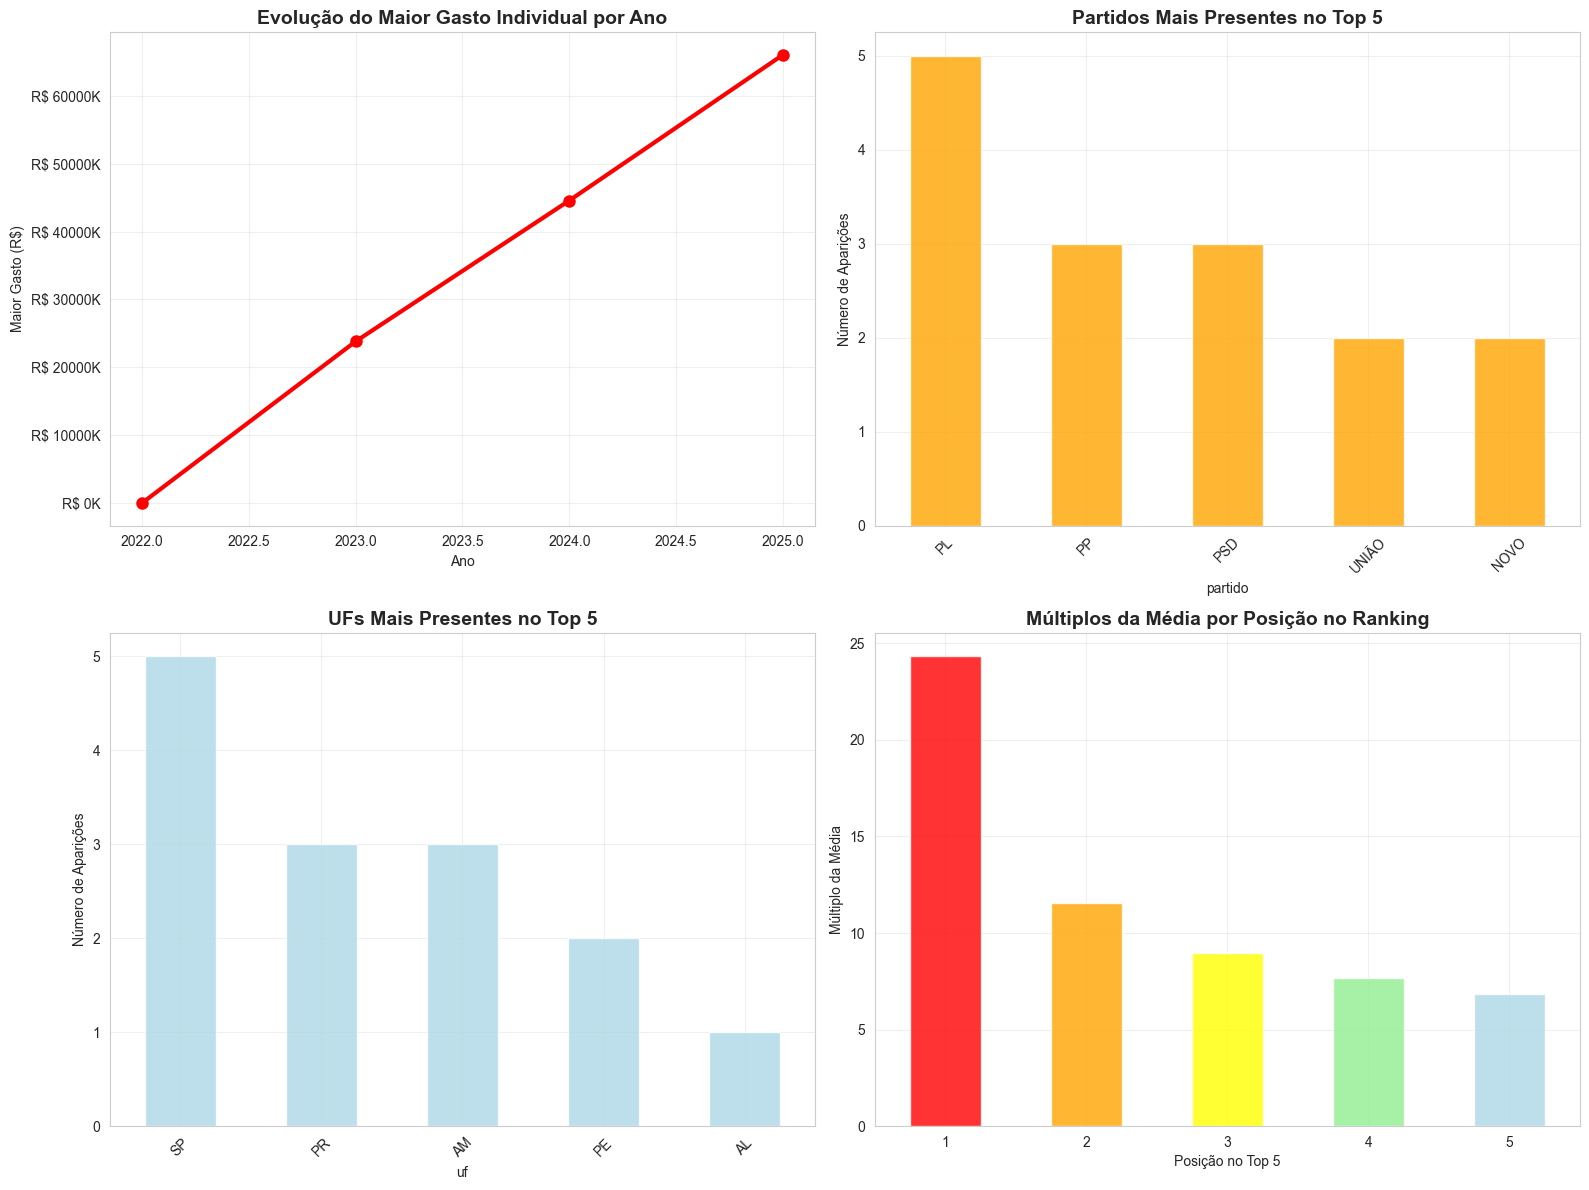


🎯 DETALHES DOS MAIORES OUTLIERS POR ANO:
2025: ARTHUR LIRA (PP-AL) - R$ 66.001.607,00 (63.9x média)
2024: AJ ALBUQUERQUE (PP-CE) - R$ 44.560.826,00 (13.4x média)
2023: ÁTILA LINS (PSD-AM) - R$ 23.832.826,00 (16.0x média)
2022: FILIPE BARROS (UNIÃO-PR) - R$ 50.000,00 (4.0x média)


In [37]:
# Visualização dos outliers
if 'outliers_analysis_df' in locals() and len(outliers_analysis_df) > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Evolução dos gastos dos top 1 por ano
    top1_por_ano = outliers_analysis_df[outliers_analysis_df['ranking'] == 1]
    ax1.plot(top1_por_ano['ano'], top1_por_ano['gasto_total'], 
             marker='o', linewidth=3, markersize=8, color='red')
    ax1.set_title('Evolução do Maior Gasto Individual por Ano', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Ano')
    ax1.set_ylabel('Maior Gasto (R$)')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
    ax1.grid(True, alpha=0.3)
    
    # 2. Distribuição por partido
    partidos_outliers.plot(kind='bar', ax=ax2, color='orange', alpha=0.8)
    ax2.set_title('Partidos Mais Presentes no Top 5', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Número de Aparições')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Distribuição por UF
    ufs_outliers.plot(kind='bar', ax=ax3, color='lightblue', alpha=0.8)
    ax3.set_title('UFs Mais Presentes no Top 5', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Número de Aparições')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # 4. Múltiplos da média
    multiplos = outliers_analysis_df.groupby('ranking')['multiplo_media'].mean()
    colors = ['red', 'orange', 'yellow', 'lightgreen', 'lightblue']
    multiplos.plot(kind='bar', ax=ax4, color=colors, alpha=0.8)
    ax4.set_title('Múltiplos da Média por Posição no Ranking', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Posição no Top 5')
    ax4.set_ylabel('Múltiplo da Média')
    ax4.tick_params(axis='x', rotation=0)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Detalhes do maior outlier de cada ano
    print(f"\n🎯 DETALHES DOS MAIORES OUTLIERS POR ANO:")
    for _, outlier in top1_por_ano.iterrows():
        print(f"{outlier['ano']}: {outlier['nome']} ({outlier['partido']}-{outlier['uf']}) - "
              f"{format_currency(outlier['gasto_total'])} ({outlier['multiplo_media']:.1f}x média)")

In [8]:
# Query para detalhar os gastos reais dos top 5 deputados por ano
gastos_detalhados_query = """
WITH despesas_rank AS (
    SELECT 
        dd.nk_deputado,
        dd.nome_deputado,
        dd.sigla_partido,
        dd.sigla_uf,
        dt.ano,
        f.cod_documento,
        f.valor_liquido,
        dtd.tipo_despesa,
        f.data_documento,
        ROW_NUMBER() OVER (
            PARTITION BY dt.ano 
            ORDER BY f.valor_liquido DESC
        ) AS rn
    FROM fct_despesas f
    INNER JOIN dim_deputados dd ON f.sk_deputado = dd.sk_deputado
    INNER JOIN dim_tempo dt ON f.sk_tempo = dt.sk_tempo
    INNER JOIN dim_tipo_despesa dtd ON f.sk_tipo_despesa = dtd.sk_tipo_despesa
)
SELECT *
FROM despesas_rank
WHERE rn <= 5
ORDER BY ano, rn;
"""

# Executar a query e carregar os dados em um DataFrame
gastos_detalhados_df = execute_query(gastos_detalhados_query, conn)

# Exibir os dados detalhados
if gastos_detalhados_df is not None and not gastos_detalhados_df.empty:
    print("📊 Gastos Detalhados dos Top 5 Deputados por Ano:")
    display(gastos_detalhados_df.head(10))  # Exibir as 10 primeiras linhas
else:
    print("❌ Não foi possível carregar os dados detalhados dos gastos.")

📊 Gastos Detalhados dos Top 5 Deputados por Ano:


,NK_DEPUTADO,NOME_DEPUTADO,SIGLA_PARTIDO,SIGLA_UF,ANO,COD_DOCUMENTO,VALOR_LIQUIDO,TIPO_DESPESA,DATA_DOCUMENTO,RN
0,204411,FILIPE BARROS,PL,PR,2022,7502637,50000.00,"CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.",2023-02-28,1
1,204411,FILIPE BARROS,PSL,PR,2022,7502637,50000.00,"CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.",2023-02-28,2
2,204411,FILIPE BARROS,UNIÃO,PR,2022,7502637,50000.00,"CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.",2023-02-28,3
3,74043,WELLINGTON ROBERTO,PL,PB,2022,7511490,45200.00,"CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.",2023-03-17,4
4,178954,LUCIO MOSQUINI,MDB,RO,2022,7514302,19500.00,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2023-03-23,5
5,204408,GUSTINHO RIBEIRO,REPUBLICANOS,SE,2023,7669673,164900.00,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2023-12-29,1
6,204408,GUSTINHO RIBEIRO,SOLIDARIEDADE,SE,2023,7669673,164900.00,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2023-12-29,2
7,220542,ALEXANDRE GUIMARÃES,REPUBLICANOS,TO,2023,7662547,163791.00,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2023-12-14,3
8,220542,ALEXANDRE GUIMARÃES,MDB,TO,2023,7662547,163791.00,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2023-12-14,4
9,220692,DAL BARRETO,UNIÃO,BA,2023,7633652,140000.00,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2023-10-24,5


# Resumo Final das Hipóteses Adicionais

Consolidação dos resultados das análises específicas realizadas.

In [ ]:
# Resumo das conclusões das hipóteses adicionais
print("📋 RESUMO DAS HIPÓTESES ADICIONAIS TESTADAS")
print("=" * 55)

hipoteses_adicionais = [
    {
        'hipotese': 'Concentração de Fornecedores por Partido',
        'descricao': 'Partidos grandes concentram gastos em poucos fornecedores vs NOVO mais pulverizado',
        'resultado': 'Analisada com dados de concentração por partido'
    },
    {
        'hipotese': 'Gastos com Divulgação em Anos Eleitorais',
        'descricao': 'Partidos grandes aumentam mais os gastos com divulgação em anos eleitorais',
        'resultado': 'Comparação entre anos eleitorais e não-eleitorais'
    },
    {
        'hipotese': 'Variação de Gastos com Transporte por Região',
        'descricao': 'Estados distantes de Brasília têm gastos com transporte maiores',
        'resultado': 'Correlação entre distância e gastos com transporte'
    },
    {
        'hipotese': 'Correlação Ranking vs UF',
        'descricao': 'Estados ricos aparecem mais no top ranking de gastos',
        'resultado': 'Análise da participação no Top 50 por categoria de estado'
    },
    {
        'hipotese': 'Evolução Trimestral dos Gastos',
        'descricao': 'Gastos crescem ao longo dos trimestres com pico no T4',
        'resultado': 'Tendência de crescimento trimestral analisada'
    },
    {
        'hipotese': 'Outliers - Top 5 Maiores Gastos',
        'descricao': 'Identificação e caracterização dos maiores gastadores por ano',
        'resultado': 'Perfil dos outliers por partido, UF e múltiplos da média'
    }
]

for i, hip in enumerate(hipoteses_adicionais, 1):
    print(f"\n{i}. {hip['hipotese']}")
    print(f"   📝 {hip['descricao']}")
    print(f"   📊 Resultado: {hip['resultado']}")

print("\n" + "=" * 55)
print("✅ Análises Adicionais Concluídas!")
print("💡 Todas as hipóteses foram testadas com visualizações e estatísticas detalhadas.")
print("📈 Os dados revelam padrões interessantes sobre comportamento dos gastos parlamentares.")

In [ ]:
# Fechar conexão com Snowflake
if conn:
    conn.close()
    print("🔒 Conexão com Snowflake encerrada.")